In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_8_B1H_Inst_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_8_B1H_Inst_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_8_B1H_Inst_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 16)            3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 8)              904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 64, 8)             456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 8)             0

Feb/24 11:02:50 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/24 11:02:50 pyobsbox.generator INFO: shuffle: True
Feb/24 11:02:50 pyobsbox.generator INFO: seed: 42
Feb/24 11:02:50 pyobsbox.generator INFO: batch_size: 8192
Feb/24 11:02:50 pyobsbox.generator INFO: sequence_length: 2048
Feb/24 11:02:50 pyobsbox.generator INFO: n_bunches: 256
Feb/24 11:02:50 pyobsbox.generator INFO: __len__: 1039
Feb/24 11:02:50 pyobsbox.generator INFO: fetched_log_folder: None
Feb/24 11:02:50 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/24 11:02:50 pyobsbox.generator INFO: normalization: center_scale
Feb/24 11:02:50 pyobsbox.generator INFO: normalization_pre_split: False
Feb/24 11:02:50 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Feb/24 11:02:50 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/24 11:02:50 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265984, 11)


type  fill  beam plane  q           date_time  \
7245611  Inst  6254     1     h  7 2017-09-29 05:26:15   
6888931  Inst  6703     1     h  7 2018-05-20 03:39:14   
1617646  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141806  Inst  6953     1     h  7 2018-07-21 06:32:07   
594046   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245611  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/...        292   
6888931  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...        396   
1617646  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141806  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
594046   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245611        298.0         158.0      65536  
6888931        298.0         185.0      65536  
1617646       1702.0        1235.0      65536  
6141806         73.0          24.0      65536  
594046        2991.0        1653.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
151131   Inst  7488     1     h  7 2018-12-01 08:07:14   
5116671  Inst  6700     1     h  7 2018-05-19 12:31:14   
5051606  Inst  6341     1     h  7 2017-10-28 00:04:08   
8637530  Inst  6390     1     h  7 2017-11-15 22:04:14   
8104585  Inst  6601     1     h  7 2018-04-23 14:57:24   

                                                      file  n_bunches  \
151131   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7488/...        733   
5116671  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/...       2556   
5051606  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6341/...        780   
8637530  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6390/...       1836   
8104585  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6601/...       1092   

         bunch_index  bunch_number  ts_length  
151131         970.0         201.0      65536  
5116671       2643.0        1947.0      65536  
5051606        766.0         421.0      65536  
8637530        475.0         228.0      65536  
8104585       1074.0         862.0      65536

# Loss functions

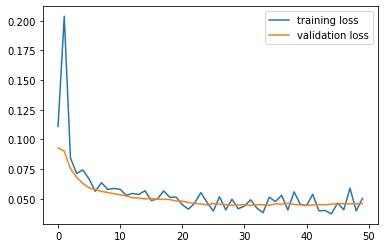

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 64s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 4s 826ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

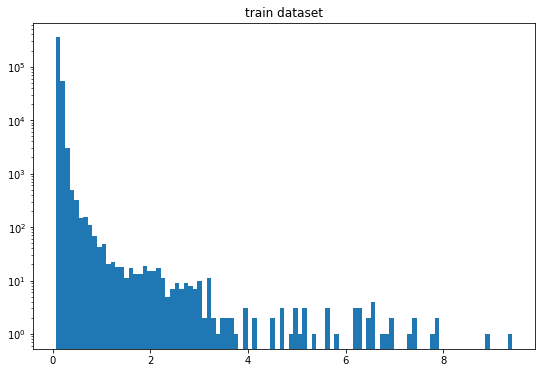

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.06280673498076794

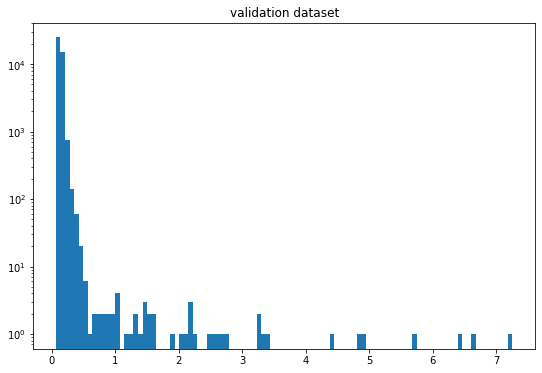

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.06280673498076794

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([368922, 251716, 265131, ...,  66486,  66618, 251438])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  368922
MAE:  9.420437699727481
n_bunches       1916
bunch_index     1869
bunch_number    1027
Name: 2914203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_06h36m14s.h5


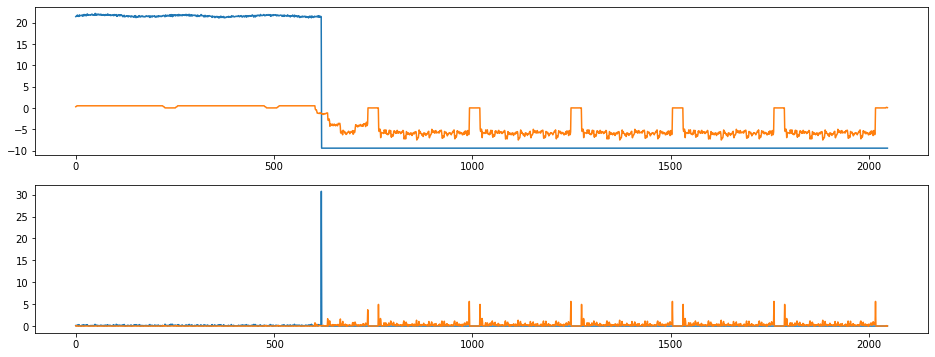

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  368922
MAE:  9.420437699727481
n_bunches       1916
bunch_index     1869
bunch_number    1027
Name: 2914203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_06h36m14s.h5


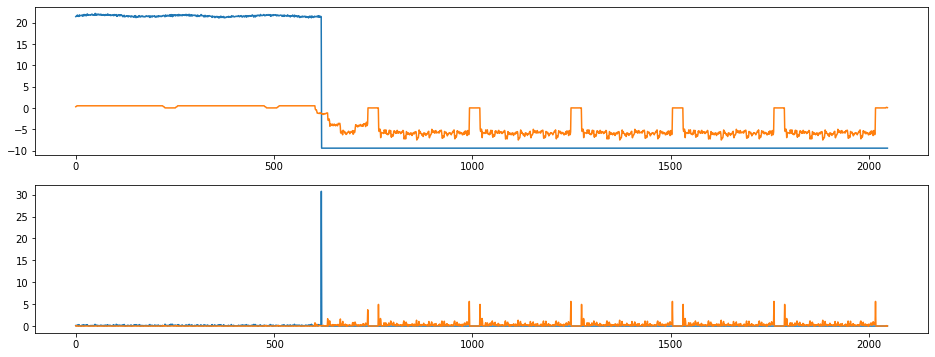

index:  251716
MAE:  8.868180079258163
n_bunches       229
bunch_index     381
bunch_number     81
Name: 5289918, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/instability_data/07489_Inst_B1H_Q7_20181201_17h10m51s.h5


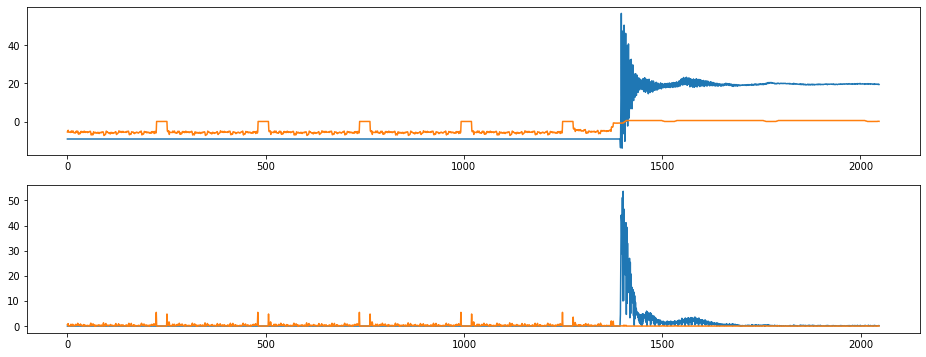

index:  265131
MAE:  7.885521346118185
n_bunches       1916
bunch_index     2480
bunch_number    1372
Name: 10961112, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_16h37m15s.h5


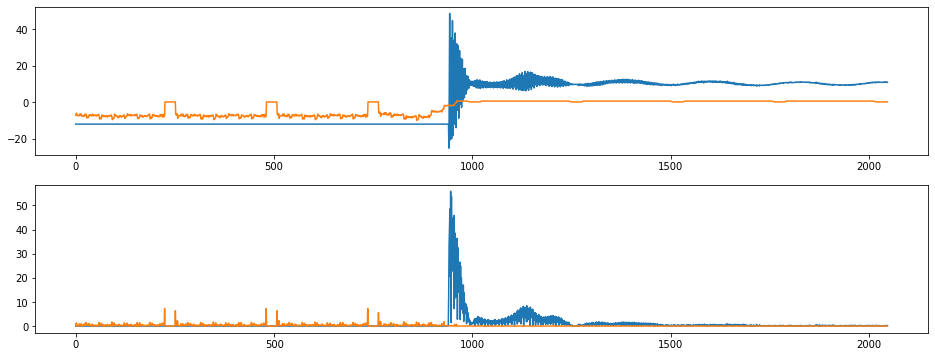

index:  347887
MAE:  7.882869166113377
n_bunches       540
bunch_index     709
bunch_number    518
Name: 8116305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7054/instability_data/07054_Inst_B1H_Q7_20180814_13h33m16s.h5


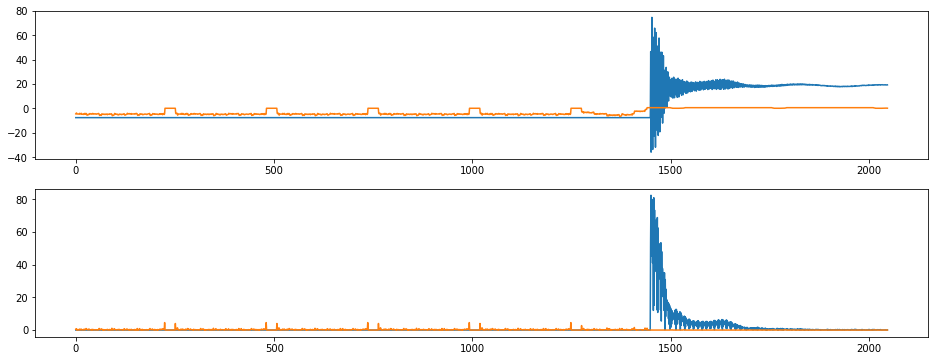

index:  246337
MAE:  7.745099862918869
n_bunches       1868
bunch_index     2241
bunch_number    1207
Name: 7721434, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_11h12m14s.h5


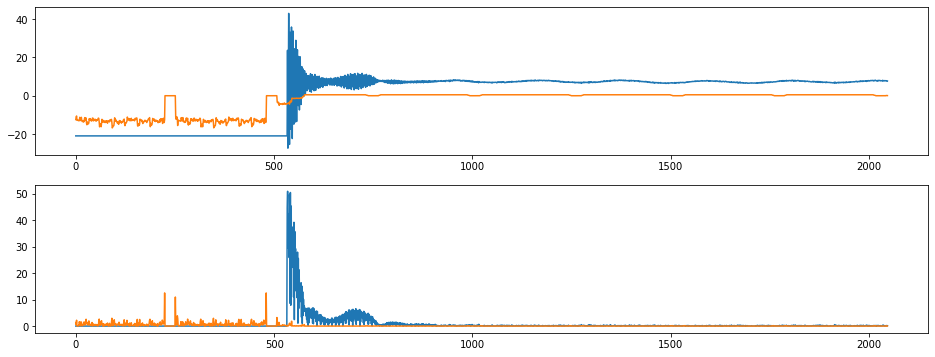

index:  200822
MAE:  7.440504940466489
n_bunches       2556
bunch_index      490
bunch_number     332
Name: 5118890, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_15h08m14s.h5


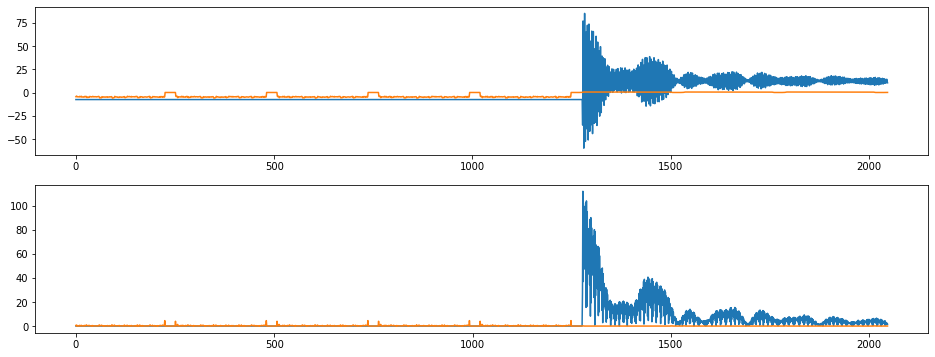

index:  295381
MAE:  7.3735634800221295
n_bunches       2556
bunch_index     1406
bunch_number    1038
Name: 7123849, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_19h24m14s.h5


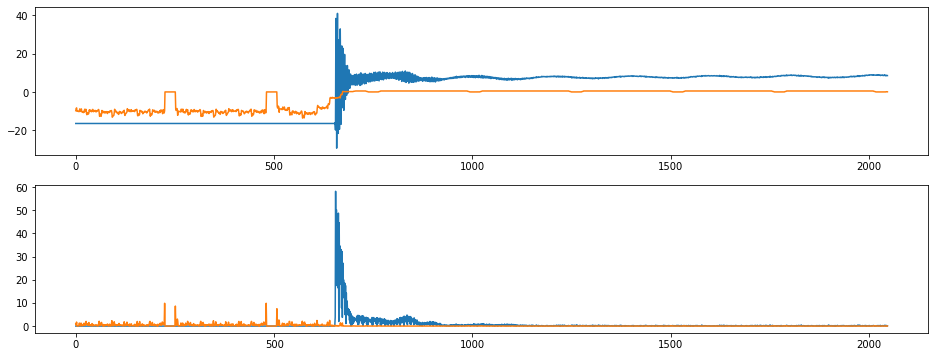

index:  212023
MAE:  7.327107513563388
n_bunches       2556
bunch_index     1377
bunch_number     997
Name: 6061586, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180521_00h53m14s.h5


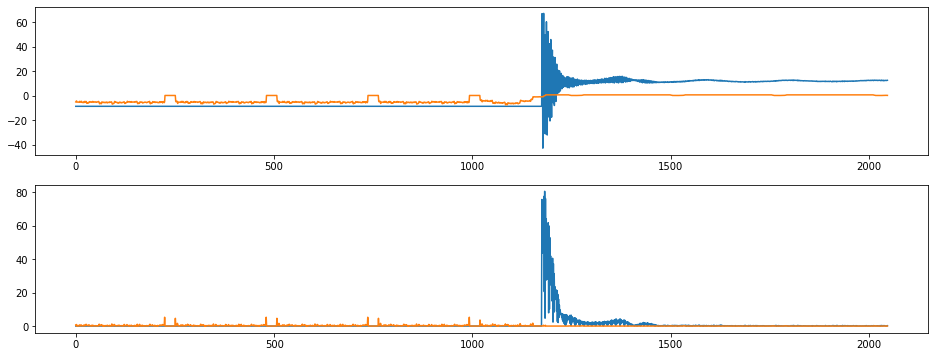

index:  329265
MAE:  6.959309564216092
n_bunches       1164
bunch_index     1102
bunch_number     453
Name: 3516411, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6892/instability_data/06892_Inst_B1H_Q7_20180707_01h22m59s.h5


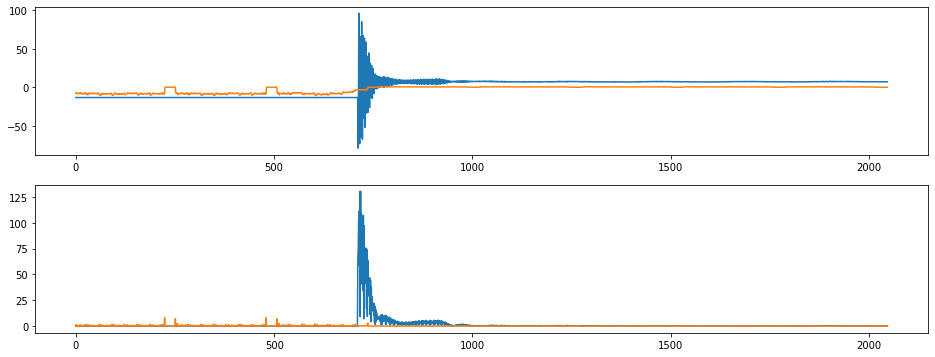

index:  240170
MAE:  6.954725380262535
n_bunches       144
bunch_index     163
bunch_number     27
Name: 6748252, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h10m15s.h5


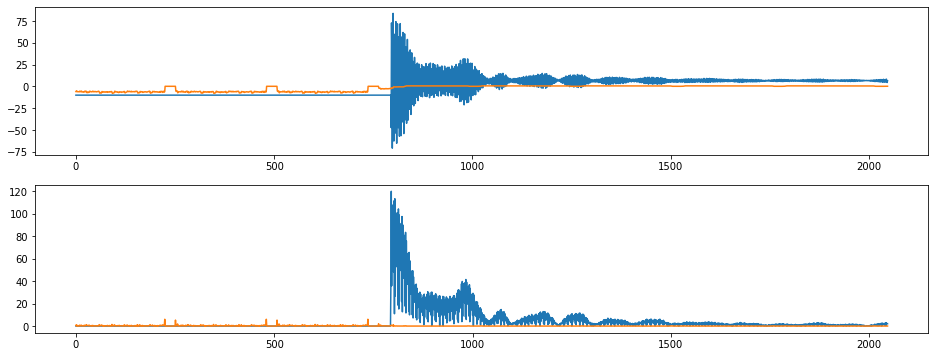

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  251438
MAE:  0.06280673498076794
n_bunches       780
bunch_index     418
bunch_number    286
Name: 8065204, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_03h35m34s.h5


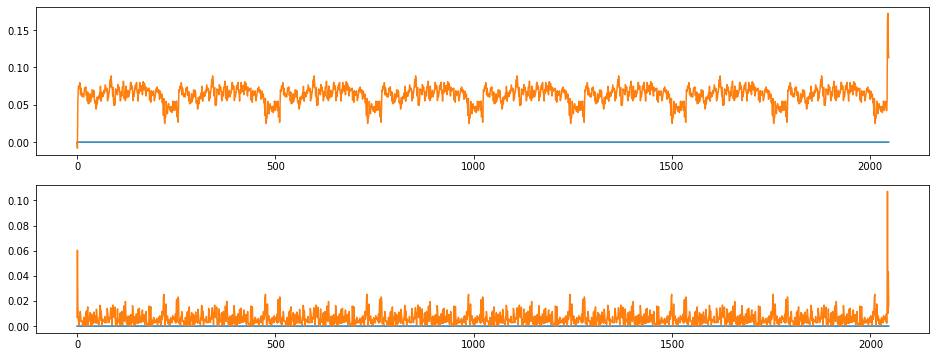

index:  66618
MAE:  0.06280673498076794
n_bunches       636
bunch_index      93
bunch_number     25
Name: 6418669, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6719/instability_data/06719_Inst_B1H_Q7_20180525_00h14m34s.h5


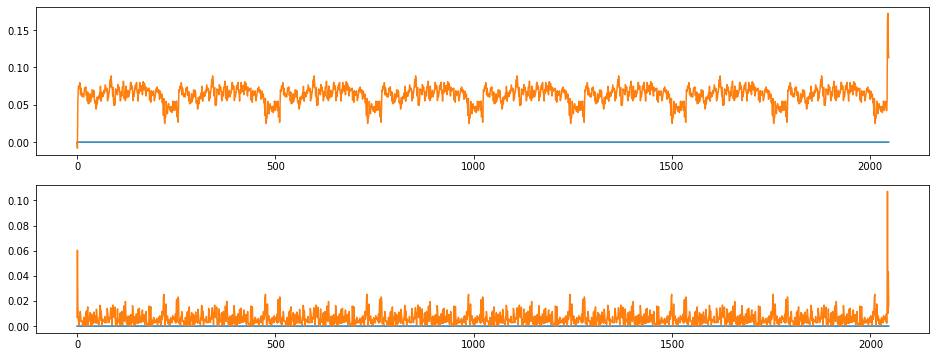

index:  66486
MAE:  0.06280673498076794
n_bunches       292
bunch_index     500
bunch_number    274
Name: 2407709, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h43m00s.h5


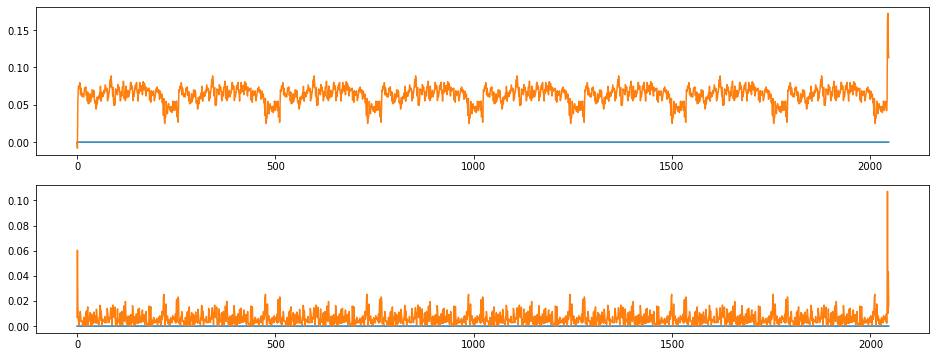

index:  33714
MAE:  0.06280673498076794
n_bunches       505
bunch_index     227
bunch_number     63
Name: 2783216, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6747/instability_data/06747_Inst_B1H_Q7_20180531_18h18m15s.h5


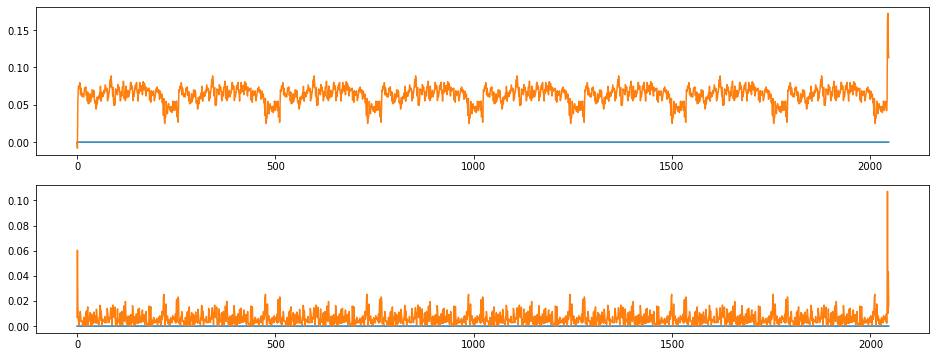

index:  112476
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     1505
bunch_number    1106
Name: 8996839, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_22h32m14s.h5


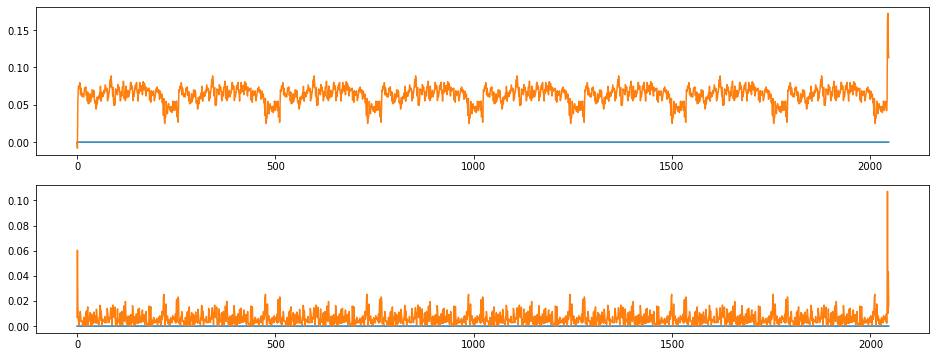

index:  12070
MAE:  0.06280673498076794
n_bunches        908
bunch_index     1029
bunch_number     543
Name: 5364364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_10h58m32s.h5


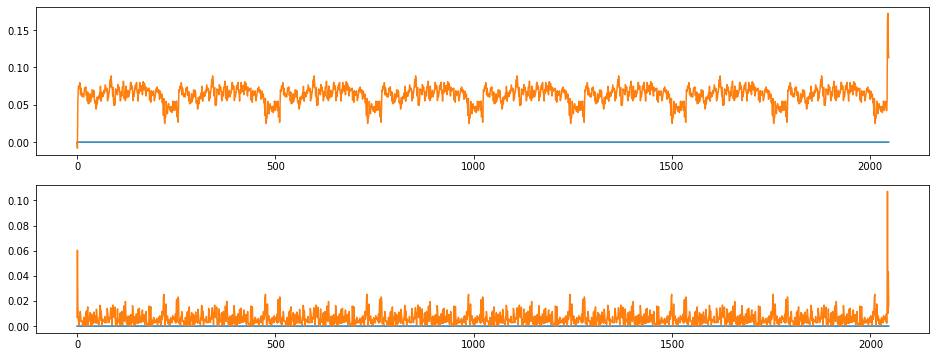

index:  280592
MAE:  0.06280673498076794
n_bunches       1868
bunch_index      399
bunch_number     204
Name: 8926573, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_18h35m14s.h5


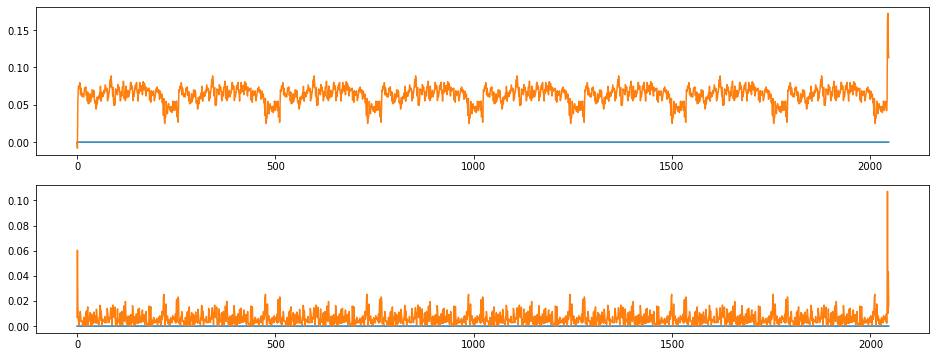

index:  66445
MAE:  0.06280673498076794
n_bunches       636
bunch_index     142
bunch_number     86
Name: 2538041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h20m55s.h5


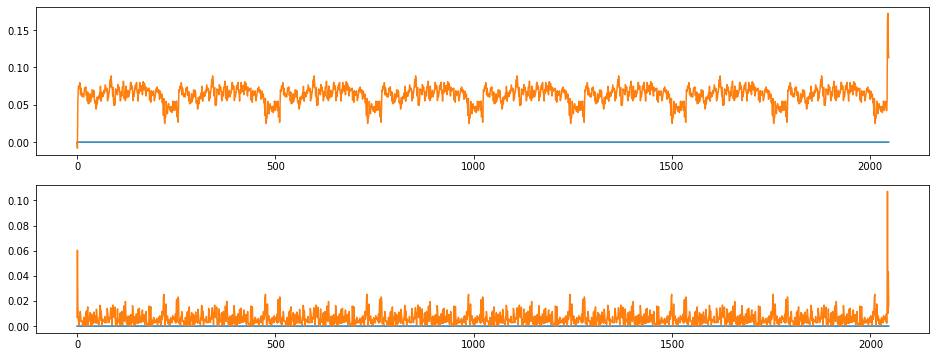

index:  101668
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     3201
bunch_number    2370
Name: 762136, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_10h01m14s.h5


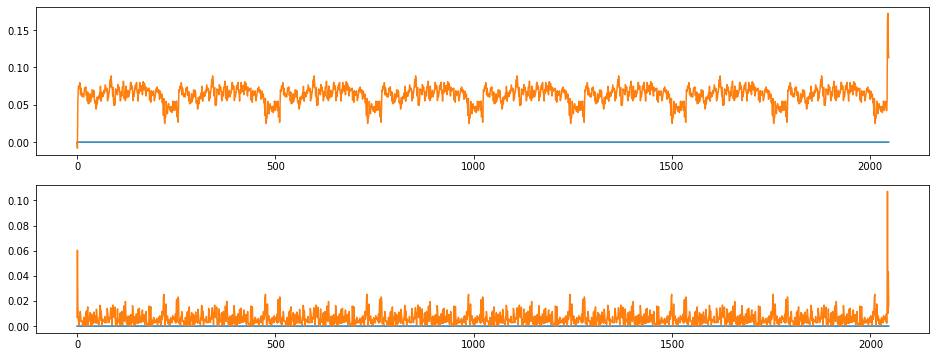

index:  269407
MAE:  0.06280673498076794
n_bunches       1292
bunch_index      719
bunch_number     322
Name: 6827359, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h21m14s.h5


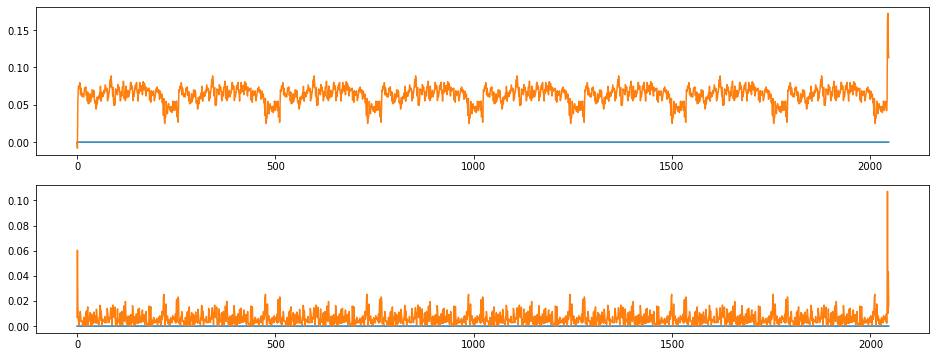

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  251438
MAE:  0.06280673498076794
n_bunches       780
bunch_index     418
bunch_number    286
Name: 8065204, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_03h35m34s.h5


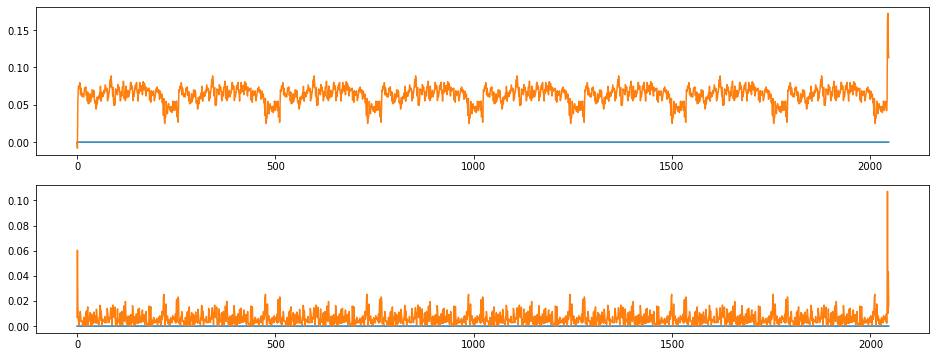

index:  66618
MAE:  0.06280673498076794
n_bunches       636
bunch_index      93
bunch_number     25
Name: 6418669, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6719/instability_data/06719_Inst_B1H_Q7_20180525_00h14m34s.h5


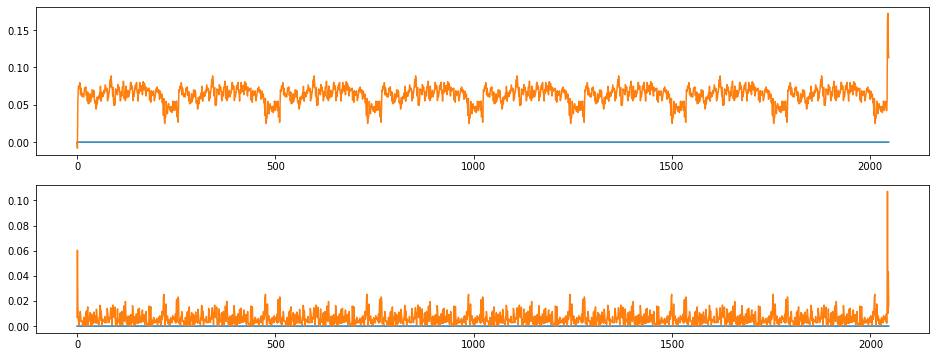

index:  66486
MAE:  0.06280673498076794
n_bunches       292
bunch_index     500
bunch_number    274
Name: 2407709, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h43m00s.h5


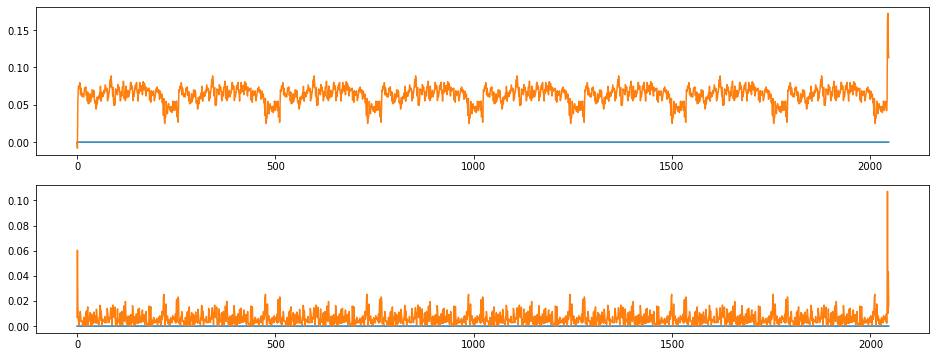

index:  33714
MAE:  0.06280673498076794
n_bunches       505
bunch_index     227
bunch_number     63
Name: 2783216, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6747/instability_data/06747_Inst_B1H_Q7_20180531_18h18m15s.h5


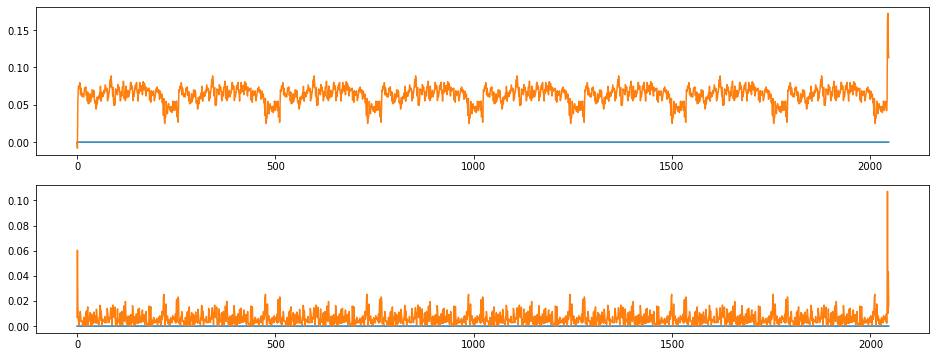

index:  112476
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     1505
bunch_number    1106
Name: 8996839, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_22h32m14s.h5


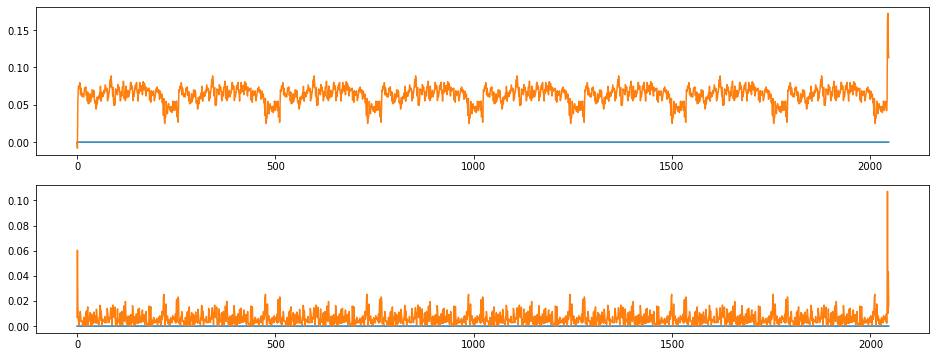

index:  12070
MAE:  0.06280673498076794
n_bunches        908
bunch_index     1029
bunch_number     543
Name: 5364364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_10h58m32s.h5


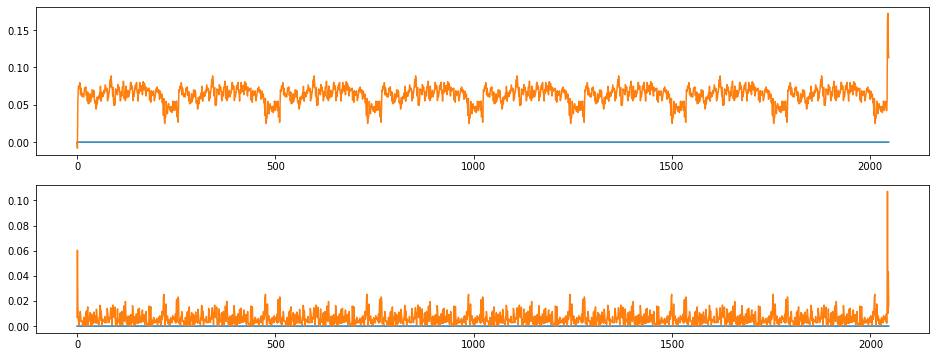

index:  280592
MAE:  0.06280673498076794
n_bunches       1868
bunch_index      399
bunch_number     204
Name: 8926573, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_18h35m14s.h5


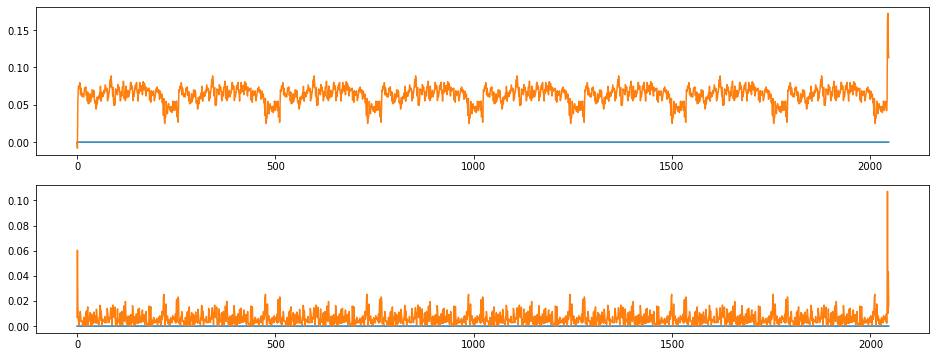

index:  66445
MAE:  0.06280673498076794
n_bunches       636
bunch_index     142
bunch_number     86
Name: 2538041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h20m55s.h5


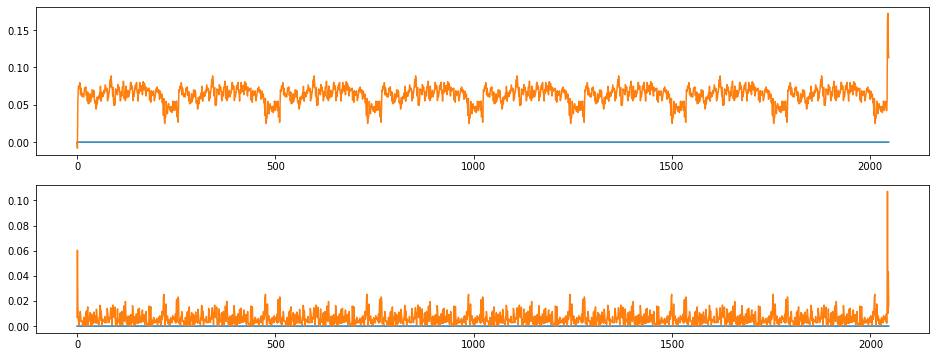

index:  101668
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     3201
bunch_number    2370
Name: 762136, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_10h01m14s.h5


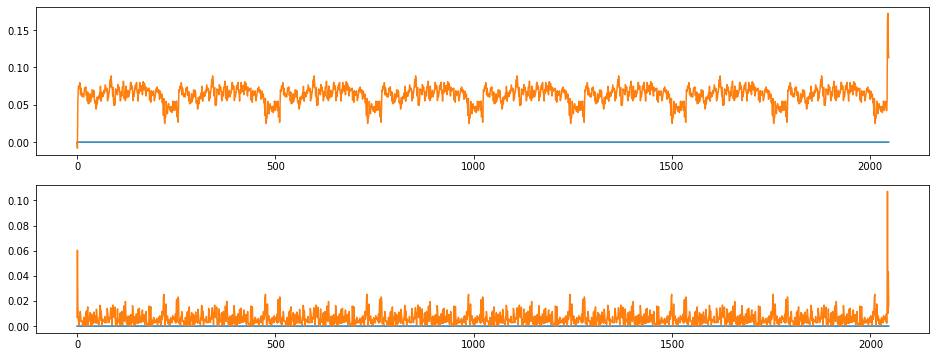

index:  269407
MAE:  0.06280673498076794
n_bunches       1292
bunch_index      719
bunch_number     322
Name: 6827359, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h21m14s.h5


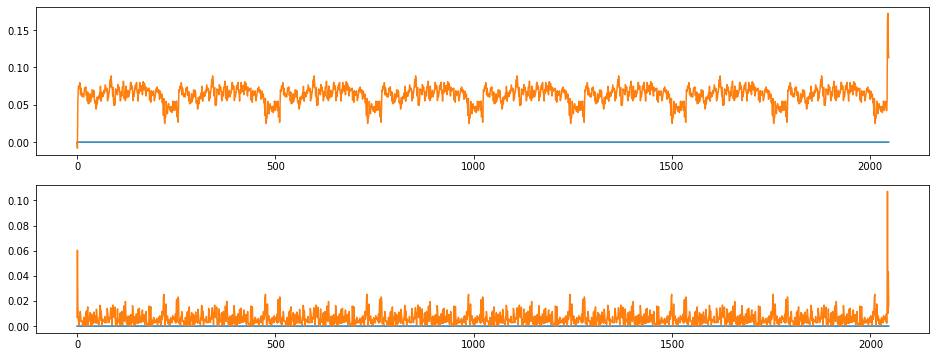

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  68255
MAE:  0.5994125907517264
n_bunches       444
bunch_index     378
bunch_number    264
Name: 3132256, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6898/instability_data/06898_Inst_B1H_Q7_20180708_00h50m20s.h5


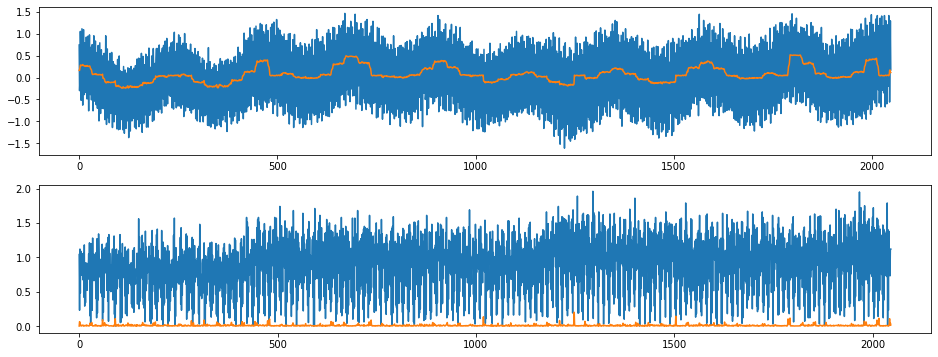

index:  384249
MAE:  0.6007322041014413
n_bunches       1212
bunch_index      959
bunch_number     688
Name: 34502, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h17m20s.h5


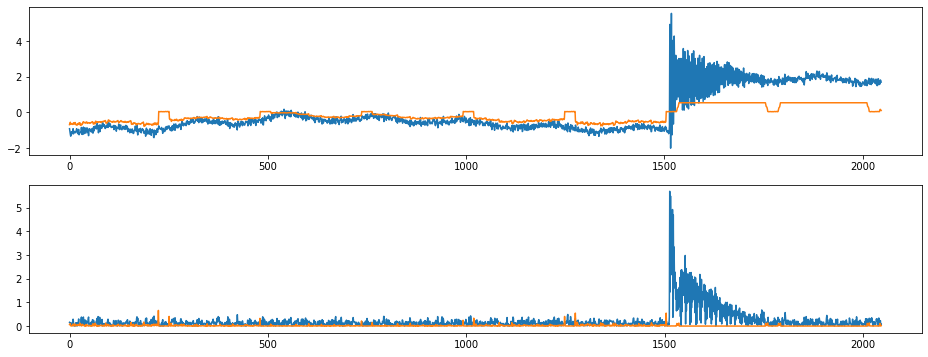

index:  173499
MAE:  0.5989993259319091
n_bunches       1227
bunch_index     2965
bunch_number    1060
Name: 9547822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_08h45m14s.h5


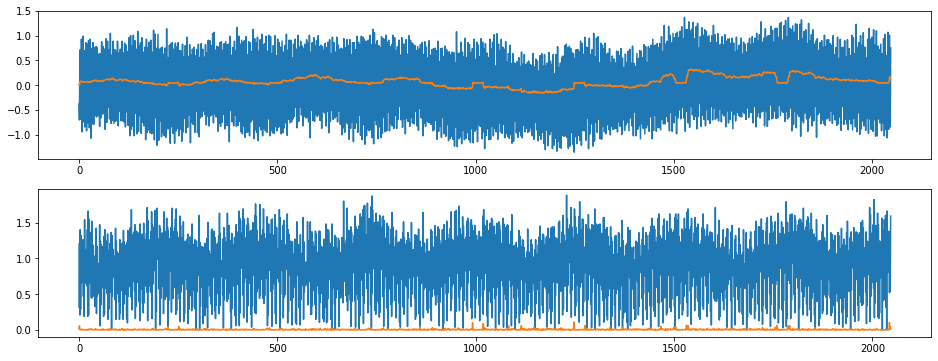

index:  304242
MAE:  0.6016300588550803
n_bunches       2556
bunch_index     2047
bunch_number    1497
Name: 3441441, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_04h08m14s.h5


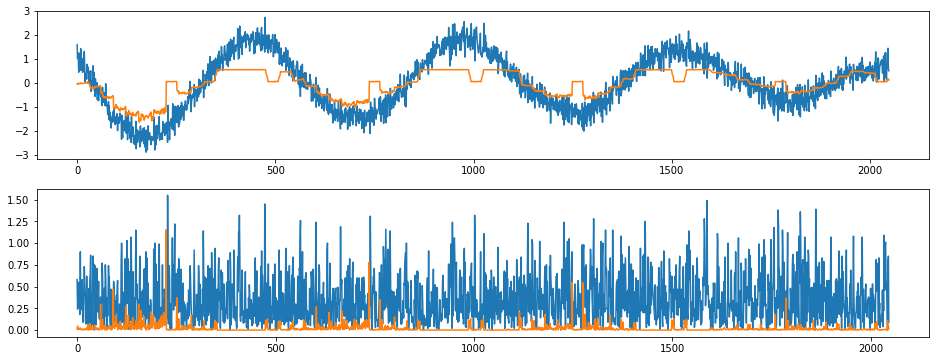

index:  107991
MAE:  0.6020490951041757
n_bunches       780
bunch_index     679
bunch_number    476
Name: 6225466, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6674/instability_data/06674_Inst_B1H_Q7_20180512_03h52m14s.h5


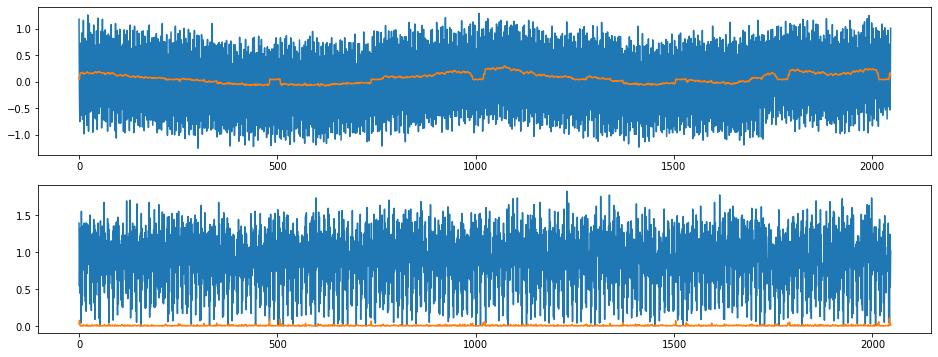

index:  44355
MAE:  0.5978749613840773
n_bunches        794
bunch_index     1042
bunch_number     313
Name: 8292288, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6624/instability_data/06624_Inst_B1H_Q7_20180430_00h48m31s.h5


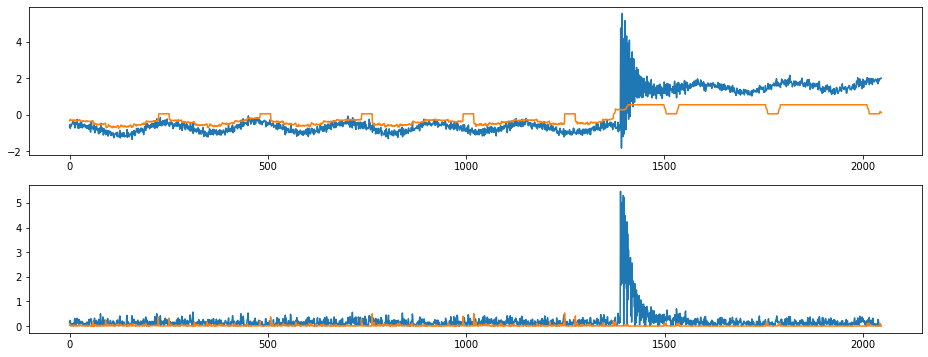

index:  400201
MAE:  0.5976587132782152
n_bunches       780
bunch_index     814
bunch_number    569
Name: 6005419, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_03h03m51s.h5


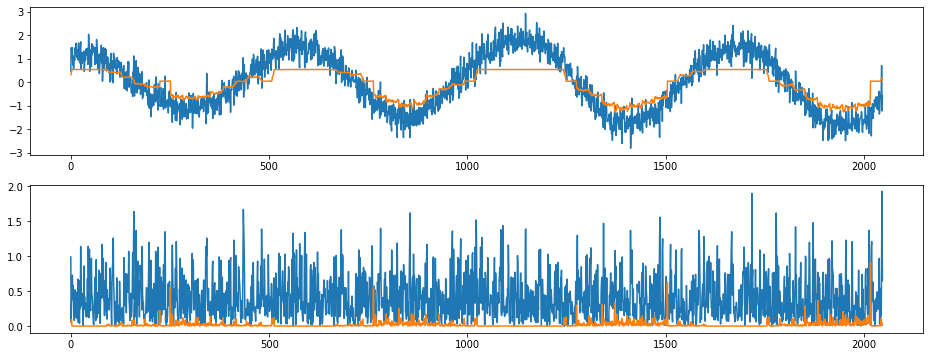

index:  405707
MAE:  0.5972092297375275
n_bunches       1916
bunch_index     2261
bunch_number    1247
Name: 3727401, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/instability_data/06245_Inst_B1H_Q7_20170926_23h15m15s.h5


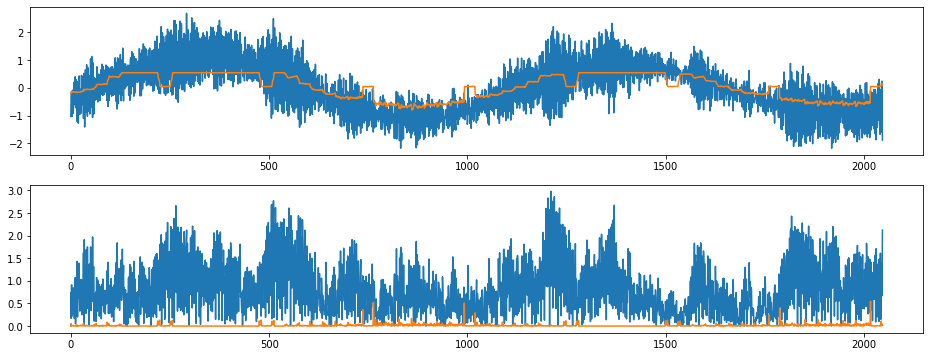

index:  28473
MAE:  0.5963221391839034
n_bunches       1068
bunch_index      159
bunch_number      84
Name: 6077847, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h12m06s.h5


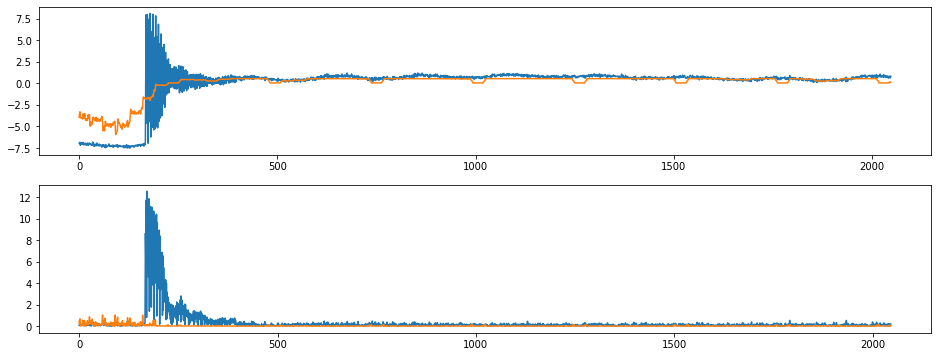

index:  221831
MAE:  0.5962634091240034
n_bunches       2556
bunch_index     1822
bunch_number    1336
Name: 778259, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181023_08h30m14s.h5


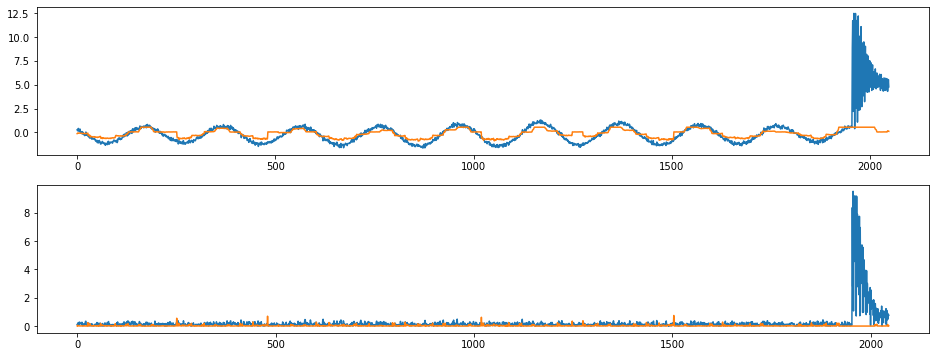

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 8, 8])

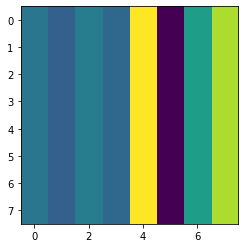

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  251438
MAE:  0.06280673498076794
n_bunches       780
bunch_index     418
bunch_number    286
Name: 8065204, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_03h35m34s.h5


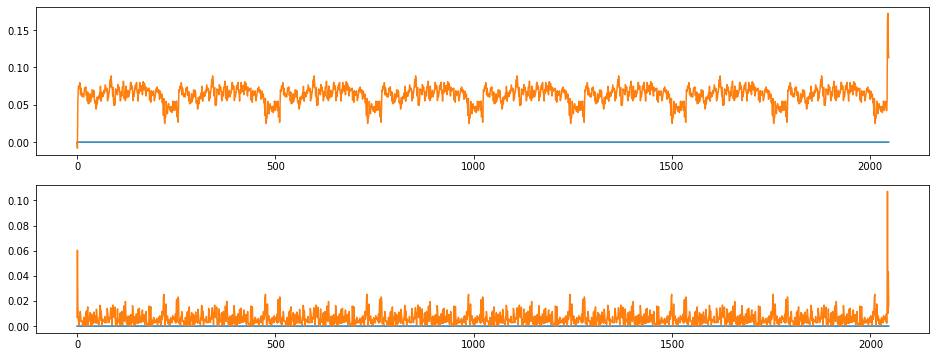

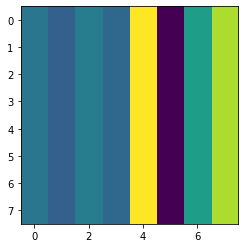

index:  66618
MAE:  0.06280673498076794
n_bunches       636
bunch_index      93
bunch_number     25
Name: 6418669, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6719/instability_data/06719_Inst_B1H_Q7_20180525_00h14m34s.h5


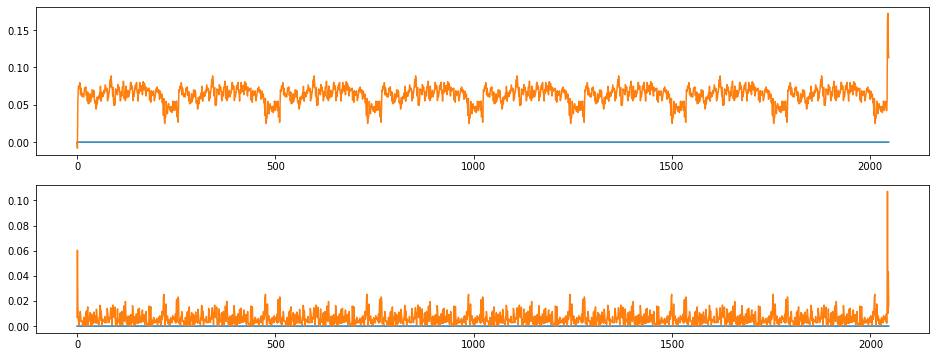

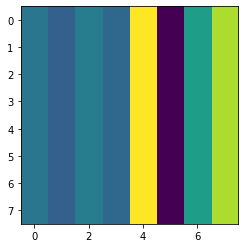

index:  66486
MAE:  0.06280673498076794
n_bunches       292
bunch_index     500
bunch_number    274
Name: 2407709, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h43m00s.h5


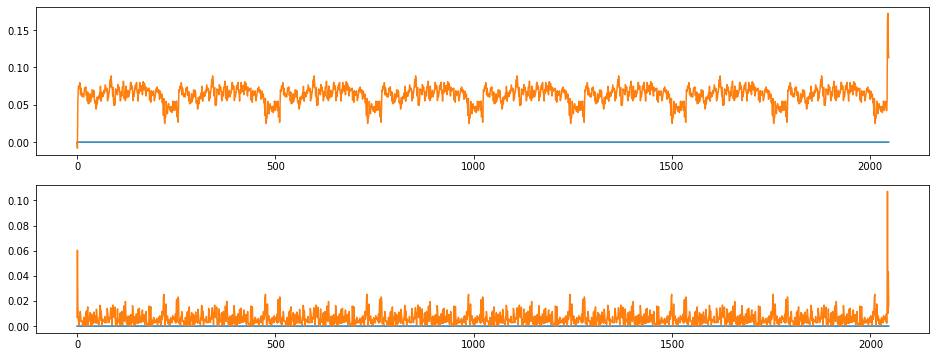

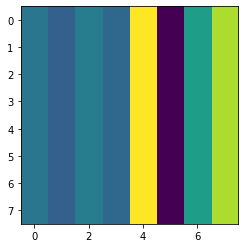

index:  33714
MAE:  0.06280673498076794
n_bunches       505
bunch_index     227
bunch_number     63
Name: 2783216, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6747/instability_data/06747_Inst_B1H_Q7_20180531_18h18m15s.h5


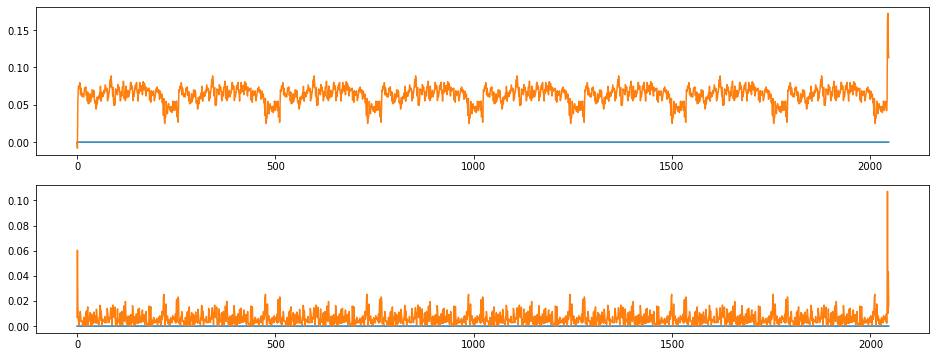

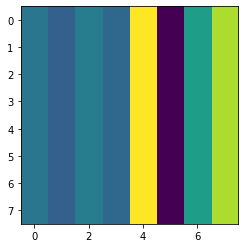

index:  112476
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     1505
bunch_number    1106
Name: 8996839, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_22h32m14s.h5


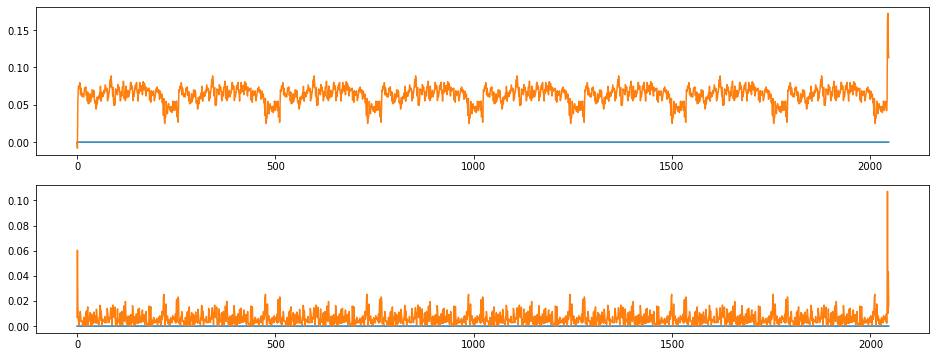

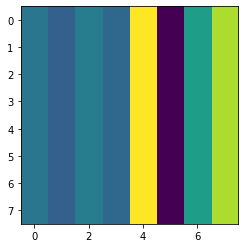

index:  12070
MAE:  0.06280673498076794
n_bunches        908
bunch_index     1029
bunch_number     543
Name: 5364364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_10h58m32s.h5


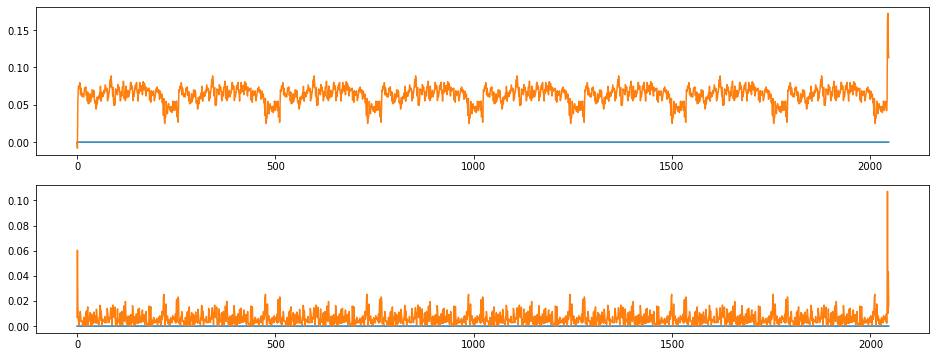

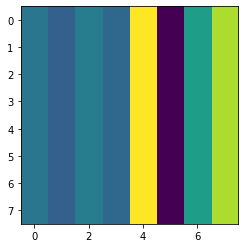

index:  280592
MAE:  0.06280673498076794
n_bunches       1868
bunch_index      399
bunch_number     204
Name: 8926573, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_18h35m14s.h5


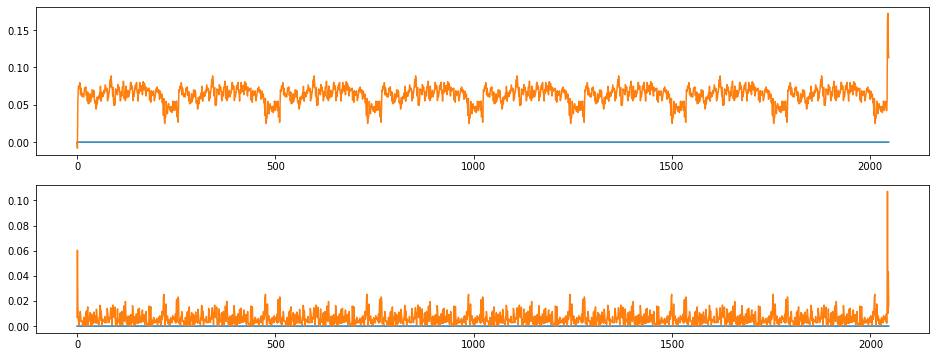

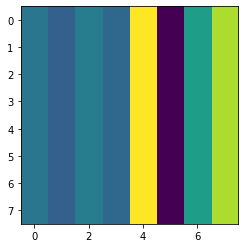

index:  66445
MAE:  0.06280673498076794
n_bunches       636
bunch_index     142
bunch_number     86
Name: 2538041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h20m55s.h5


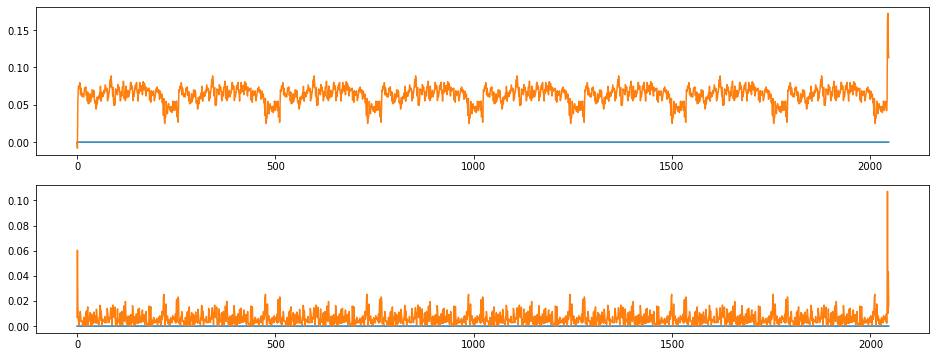

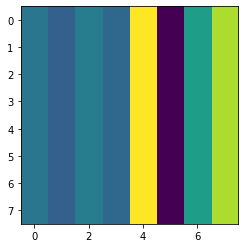

index:  101668
MAE:  0.06280673498076794
n_bunches       2556
bunch_index     3201
bunch_number    2370
Name: 762136, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_10h01m14s.h5


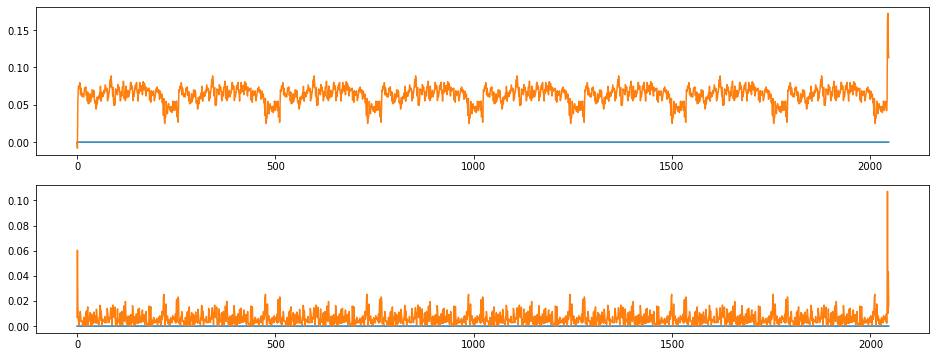

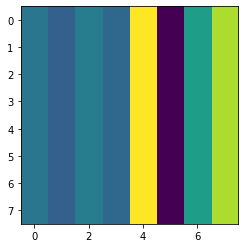

index:  269407
MAE:  0.06280673498076794
n_bunches       1292
bunch_index      719
bunch_number     322
Name: 6827359, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h21m14s.h5


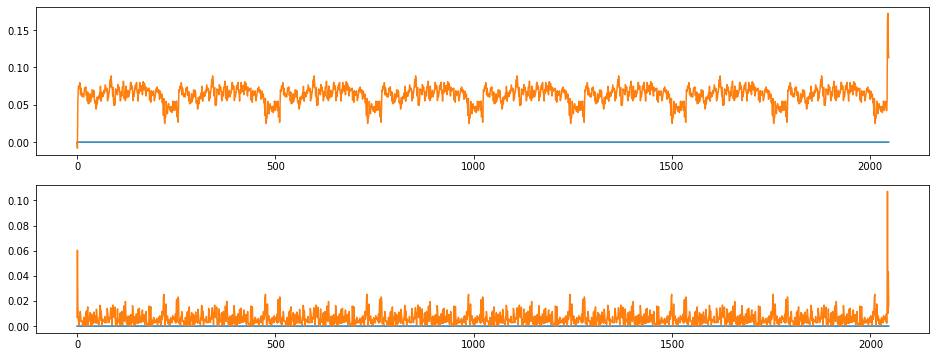

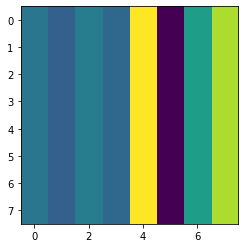

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  368922
MAE:  9.420437699727481
n_bunches       1916
bunch_index     1869
bunch_number    1027
Name: 2914203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_06h36m14s.h5


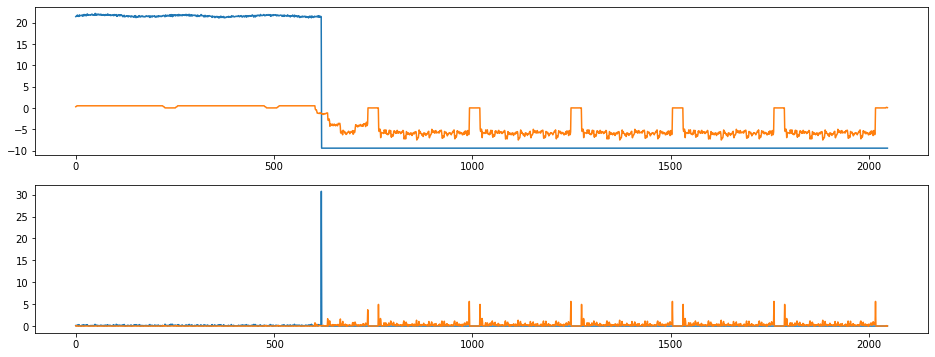

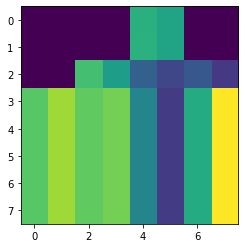

index:  251716
MAE:  8.868180079258163
n_bunches       229
bunch_index     381
bunch_number     81
Name: 5289918, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/instability_data/07489_Inst_B1H_Q7_20181201_17h10m51s.h5


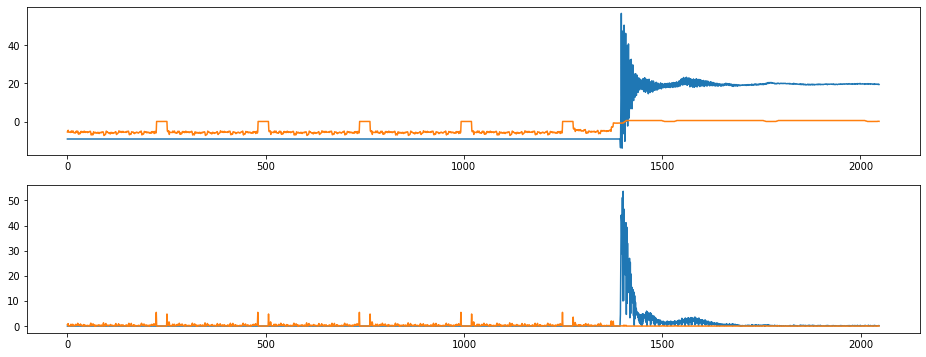

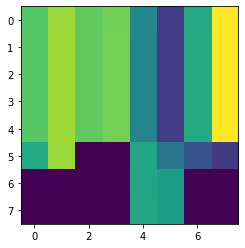

index:  265131
MAE:  7.885521346118185
n_bunches       1916
bunch_index     2480
bunch_number    1372
Name: 10961112, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_16h37m15s.h5


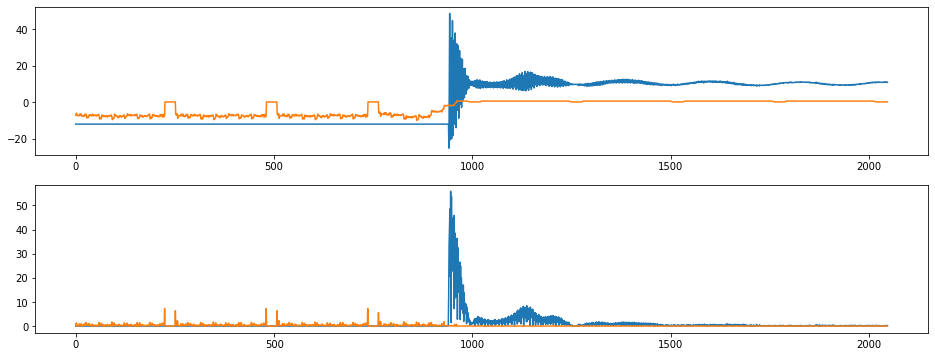

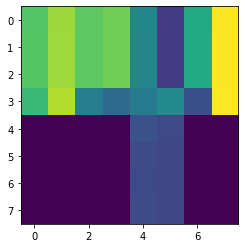

index:  347887
MAE:  7.882869166113377
n_bunches       540
bunch_index     709
bunch_number    518
Name: 8116305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7054/instability_data/07054_Inst_B1H_Q7_20180814_13h33m16s.h5


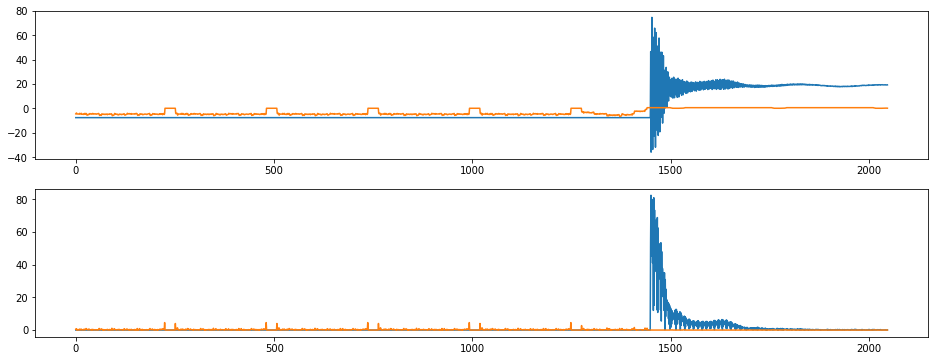

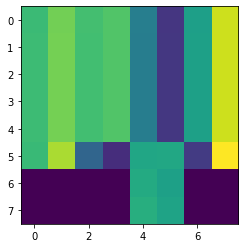

index:  246337
MAE:  7.745099862918869
n_bunches       1868
bunch_index     2241
bunch_number    1207
Name: 7721434, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_11h12m14s.h5


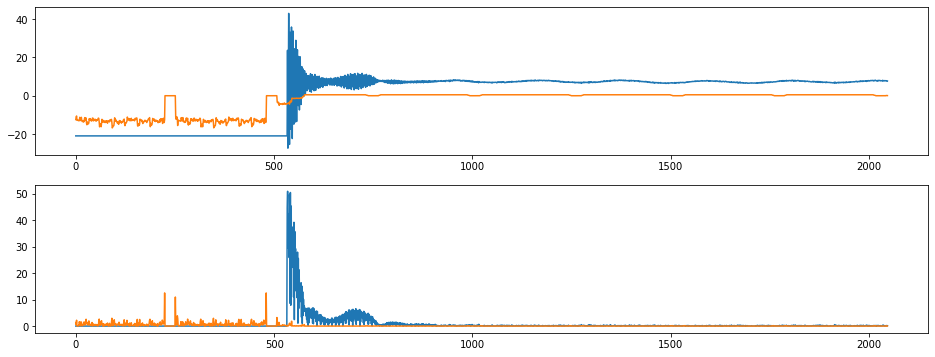

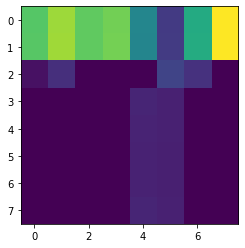

index:  200822
MAE:  7.440504940466489
n_bunches       2556
bunch_index      490
bunch_number     332
Name: 5118890, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_15h08m14s.h5


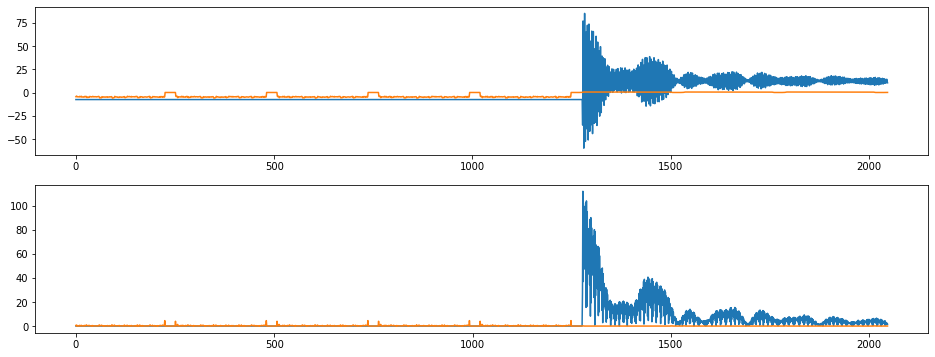

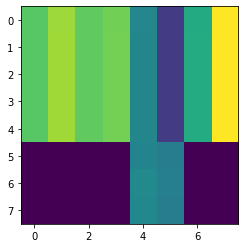

index:  295381
MAE:  7.3735634800221295
n_bunches       2556
bunch_index     1406
bunch_number    1038
Name: 7123849, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_19h24m14s.h5


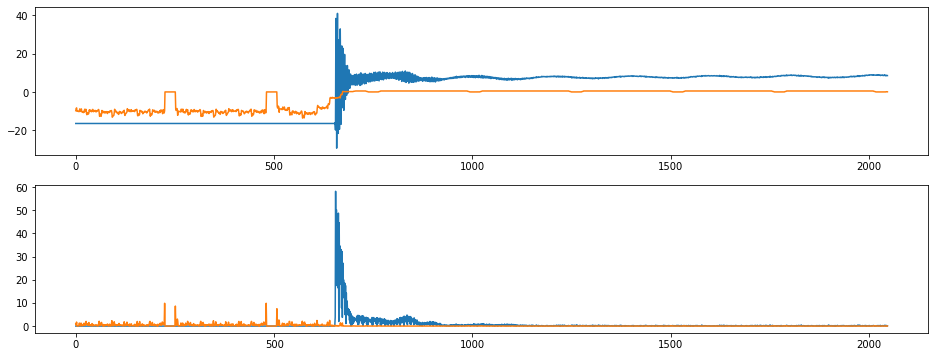

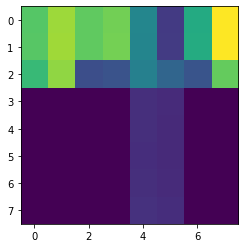

index:  212023
MAE:  7.327107513563388
n_bunches       2556
bunch_index     1377
bunch_number     997
Name: 6061586, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180521_00h53m14s.h5


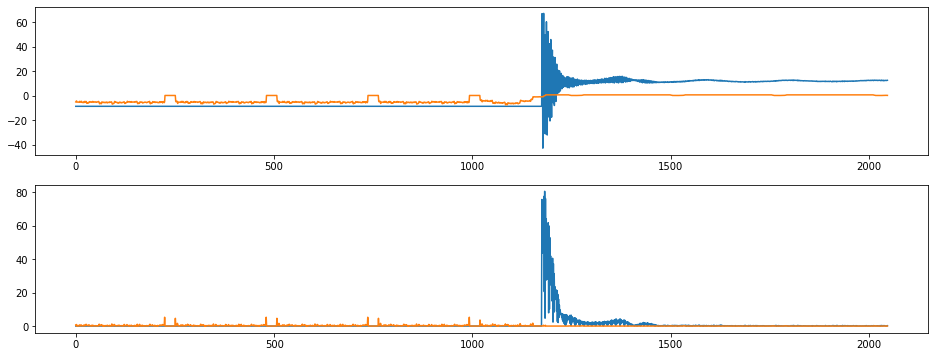

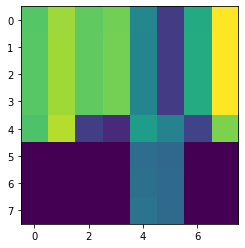

index:  329265
MAE:  6.959309564216092
n_bunches       1164
bunch_index     1102
bunch_number     453
Name: 3516411, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6892/instability_data/06892_Inst_B1H_Q7_20180707_01h22m59s.h5


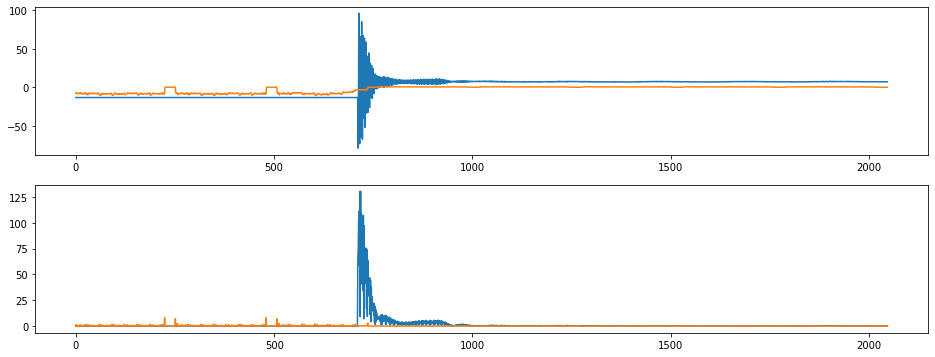

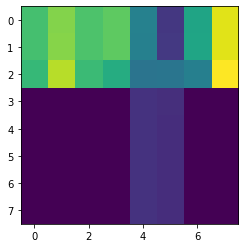

index:  240170
MAE:  6.954725380262535
n_bunches       144
bunch_index     163
bunch_number     27
Name: 6748252, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h10m15s.h5


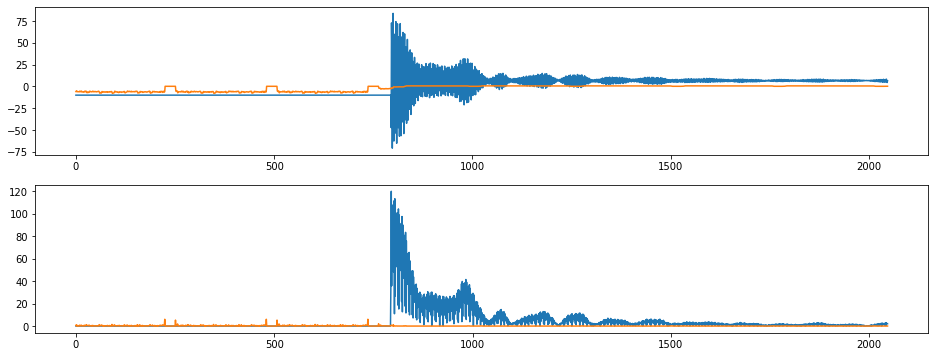

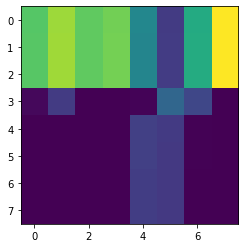

index:  166135
MAE:  6.823024992229621
n_bunches       1452
bunch_index     1664
bunch_number     701
Name: 4171455, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_10h52m15s.h5


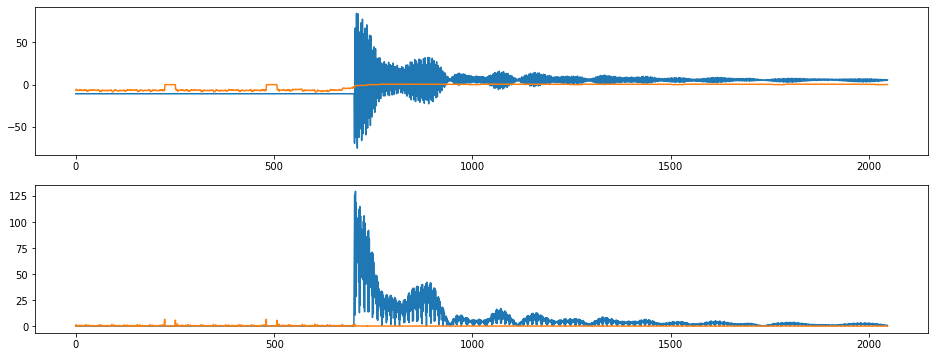

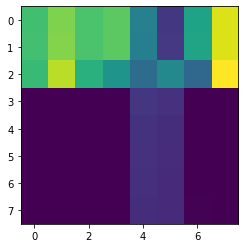

index:  122887
MAE:  6.743748320595769
n_bunches       2175
bunch_index     3150
bunch_number    2054
Name: 5894203, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_09h48m14s.h5


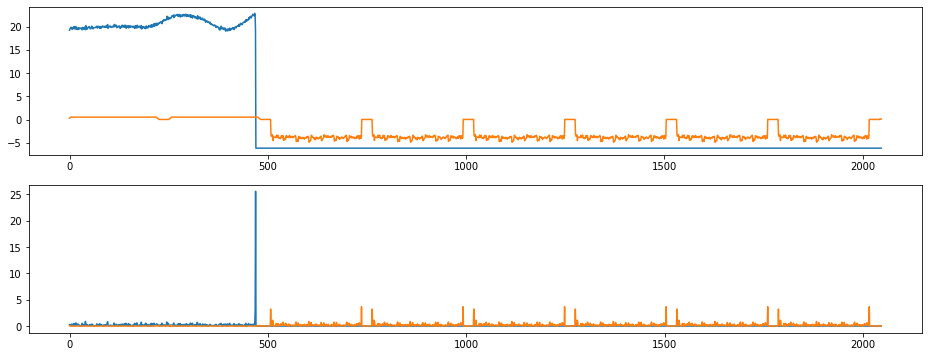

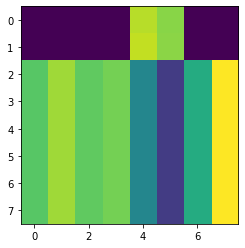

index:  387423
MAE:  6.6053498535363175
n_bunches       1916
bunch_index     2447
bunch_number    1354
Name: 429669, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_01h46m15s.h5


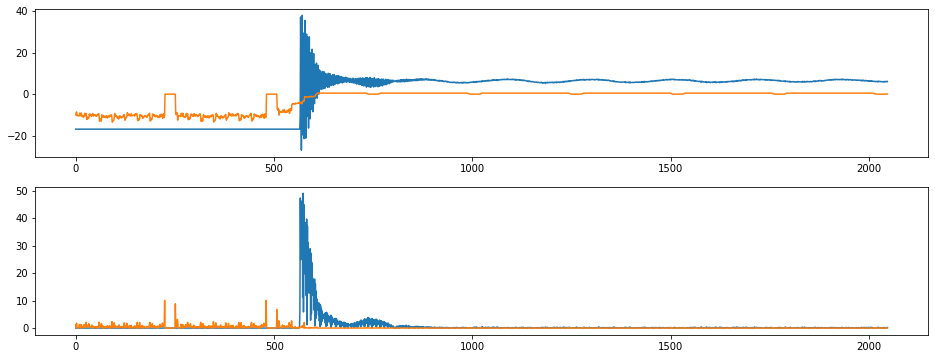

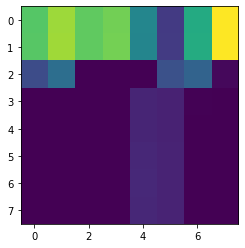

index:  351672
MAE:  6.591099794503679
n_bunches        733
bunch_index     2800
bunch_number     591
Name: 4110620, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_10h40m14s.h5


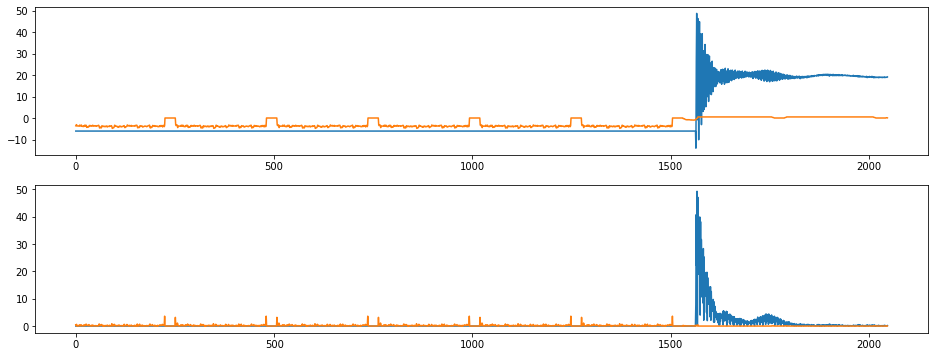

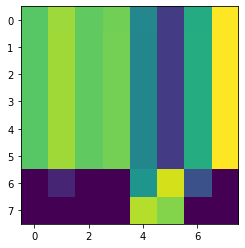

index:  151090
MAE:  6.572957210519963
n_bunches       158
bunch_index     314
bunch_number     93
Name: 8620942, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6797/instability_data/06797_Inst_B1H_Q7_20180614_23h02m14s.h5


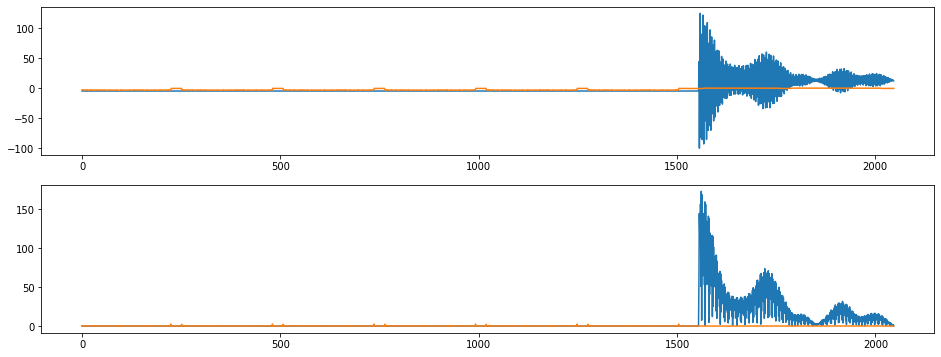

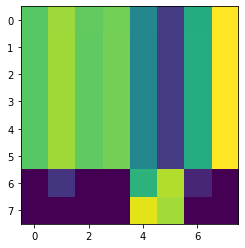

index:  262751
MAE:  6.553741012946412
n_bunches       1836
bunch_index     2623
bunch_number    1393
Name: 3463898, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_10h54m13s.h5


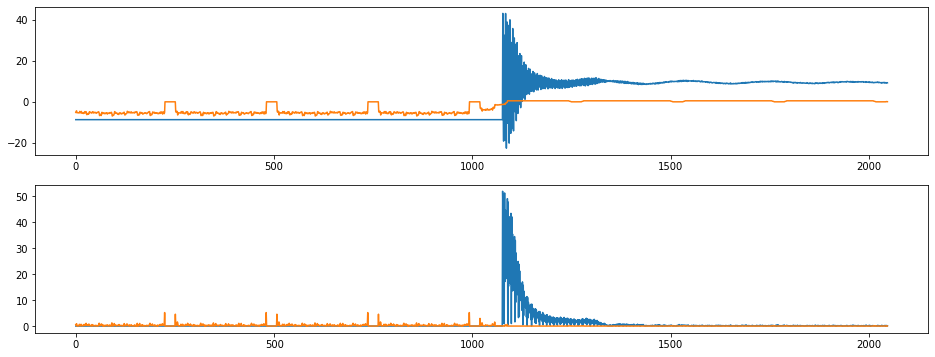

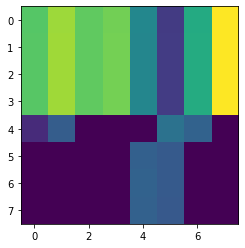

index:  247871
MAE:  6.457435595409624
n_bunches       168
bunch_index     510
bunch_number     58
Name: 6178111, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_08h42m15s.h5


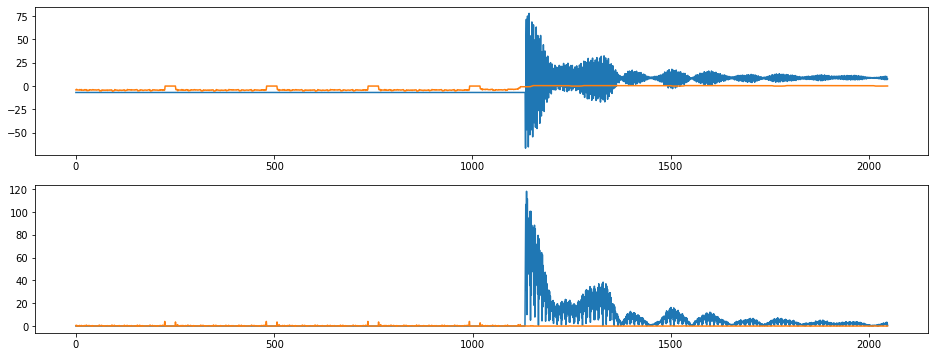

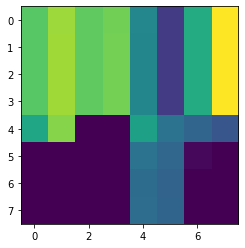

index:  69002
MAE:  6.432386043856823
n_bunches        733
bunch_index     2160
bunch_number     458
Name: 7660537, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181130_19h59m19s.h5


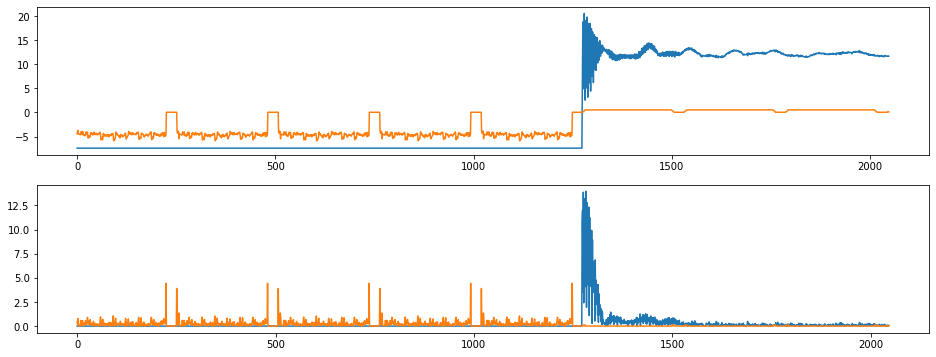

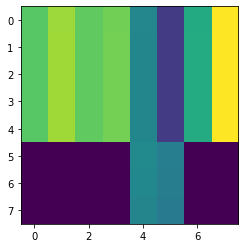

index:  337585
MAE:  6.2743374574389605
n_bunches       924
bunch_index     101
bunch_number     52
Name: 4746026, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7068/instability_data/07068_Inst_B1H_Q7_20180820_00h37m22s.h5


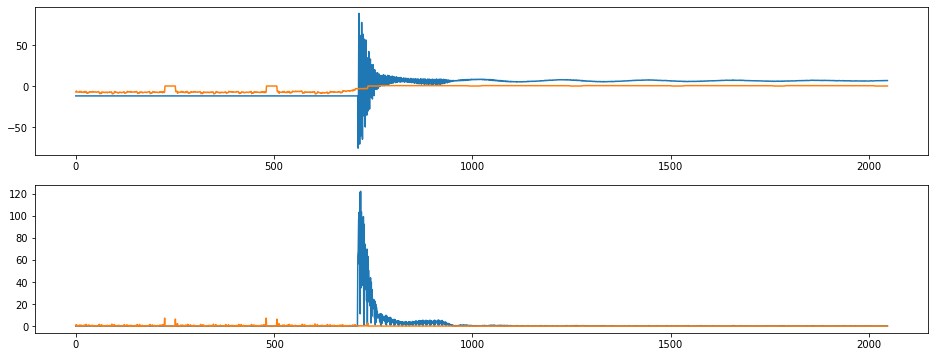

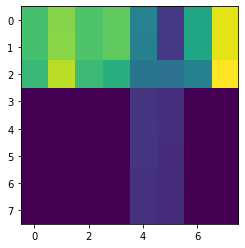

index:  235537
MAE:  6.2655975202757705
n_bunches        540
bunch_index     2067
bunch_number     384
Name: 163989, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/instability_data/07453_Inst_B1H_Q7_20181118_06h42m47s.h5


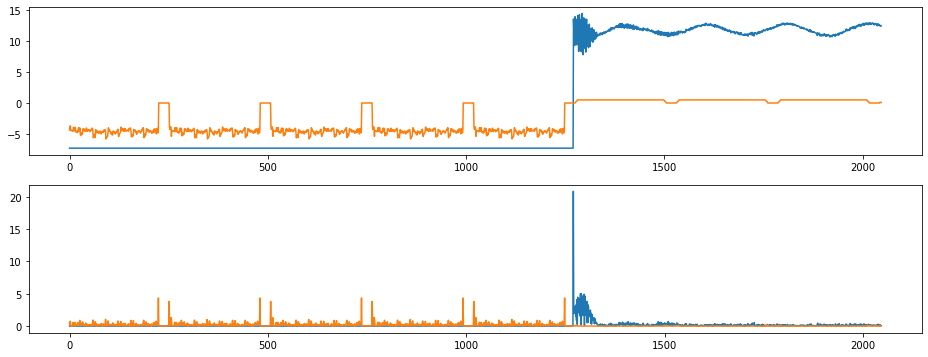

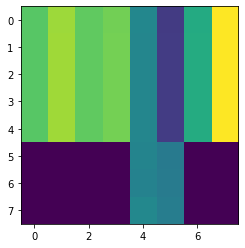

index:  238768
MAE:  6.264349420261134
n_bunches       1868
bunch_index     2715
bunch_number    1452
Name: 8118892, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h10m14s.h5


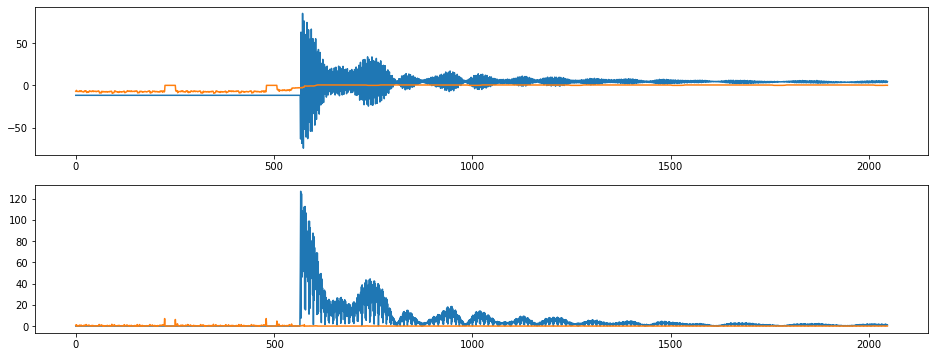

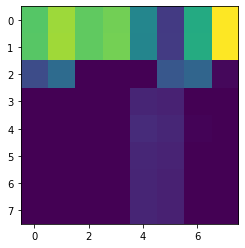

index:  231241
MAE:  6.234631882031099
n_bunches       2175
bunch_index     2583
bunch_number    1622
Name: 4984398, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_10h01m14s.h5


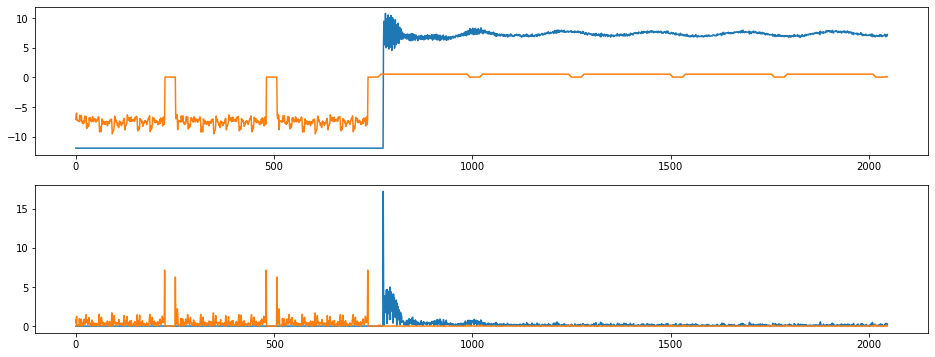

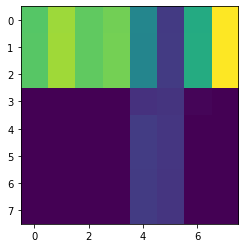

index:  279763
MAE:  6.2304503965582985
n_bunches       733
bunch_index     222
bunch_number     41
Name: 11409701, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_17h45m14s.h5


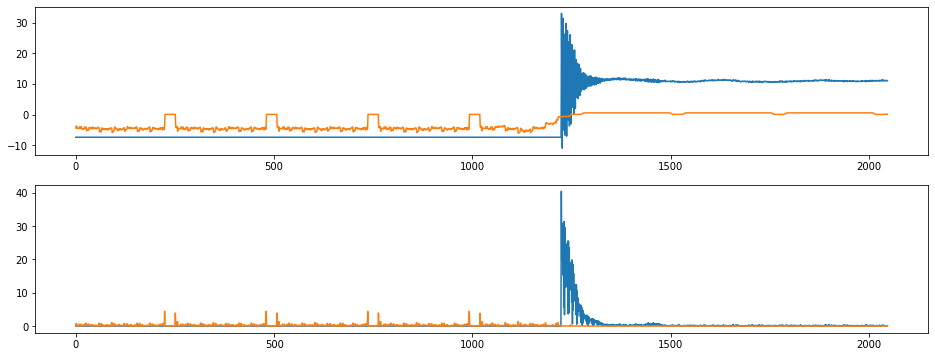

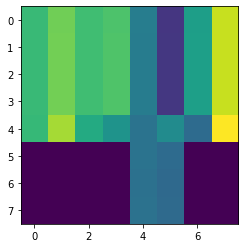

index:  282621
MAE:  6.199148451019426
n_bunches        908
bunch_index     1096
bunch_number     587
Name: 9337537, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6344/instability_data/06344_Inst_B1H_Q7_20171028_21h21m37s.h5


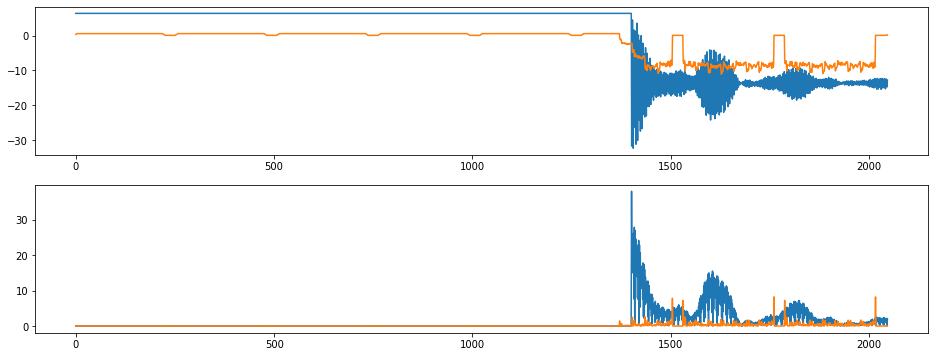

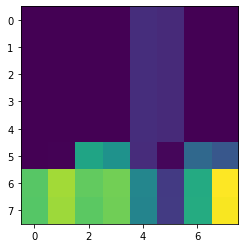

index:  169287
MAE:  5.80167402070525
n_bunches       120
bunch_index     102
bunch_number     53
Name: 7751500, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_05h25m15s.h5


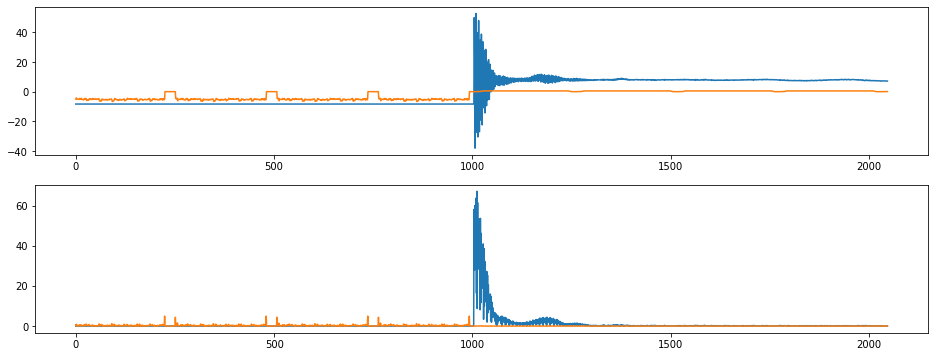

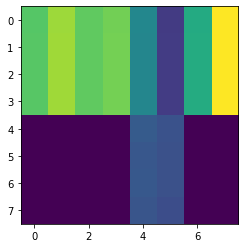

index:  353797
MAE:  5.650266220448248
n_bunches       2556
bunch_index      726
bunch_number     535
Name: 7565572, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7347/instability_data/07347_Inst_B1H_Q7_20181025_11h27m03s.h5


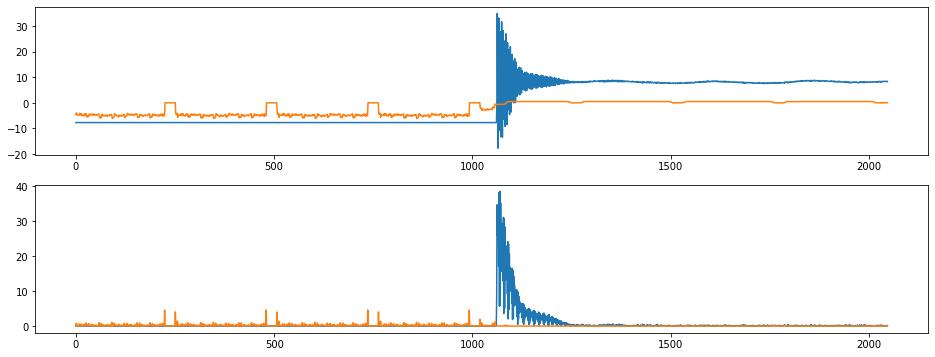

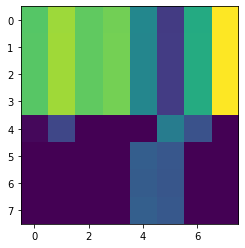

index:  175981
MAE:  5.6225916526551005
n_bunches        648
bunch_index     2443
bunch_number     456
Name: 10716663, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_06h05m15s.h5


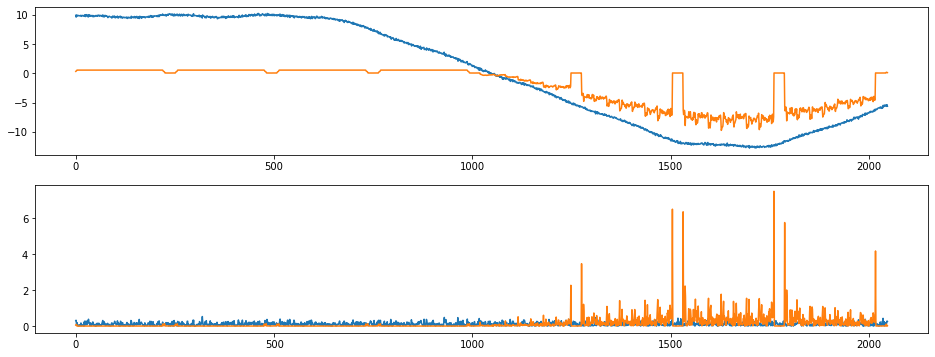

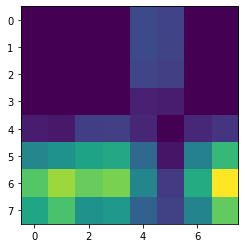

index:  127001
MAE:  5.617256112053874
n_bunches       636
bunch_index     669
bunch_number    485
Name: 9245711, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7087/instability_data/07087_Inst_B1H_Q7_20180825_13h06m11s.h5


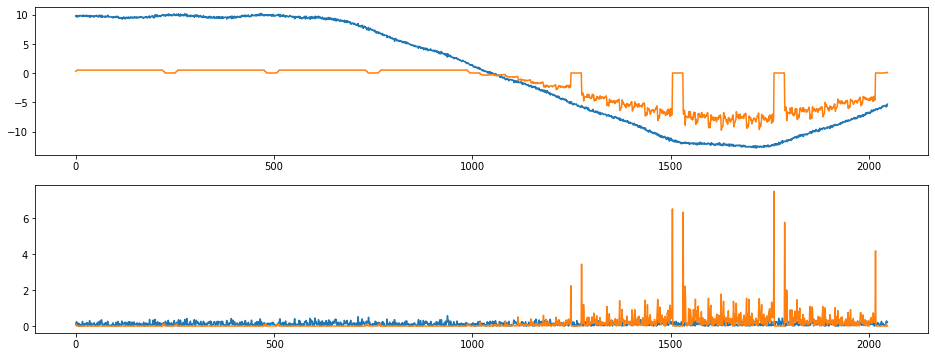

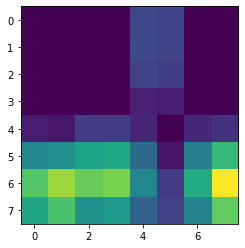

index:  319993
MAE:  5.365004631019401
n_bunches       1227
bunch_index     3150
bunch_number    1109
Name: 3107945, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6620/instability_data/06620_Inst_B1H_Q7_20180429_01h05m15s.h5


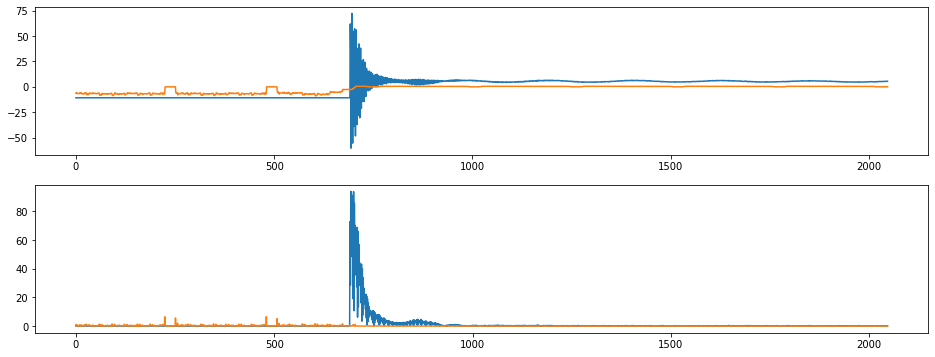

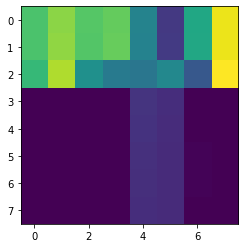

index:  277766
MAE:  5.186295145151963
n_bunches       2175
bunch_index     1041
bunch_number     662
Name: 1319630, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_17h01m14s.h5


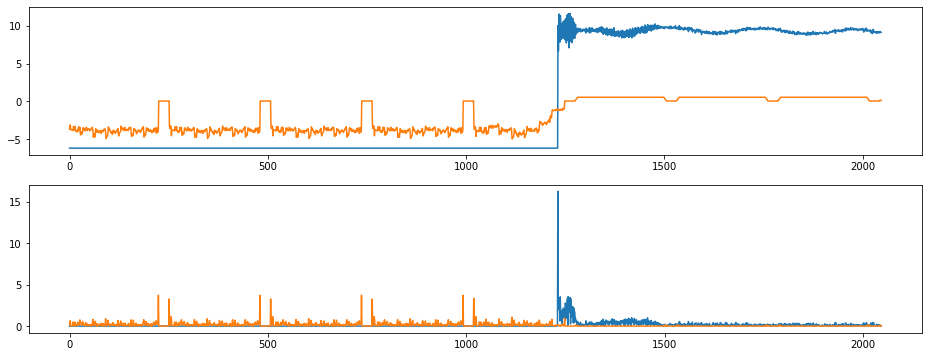

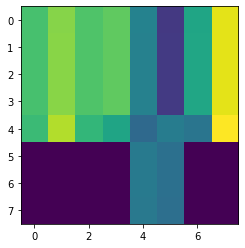

index:  283640
MAE:  5.181093021257548
n_bunches       1212
bunch_index      818
bunch_number     573
Name: 6582163, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6712/instability_data/06712_Inst_B1H_Q7_20180522_17h37m55s.h5


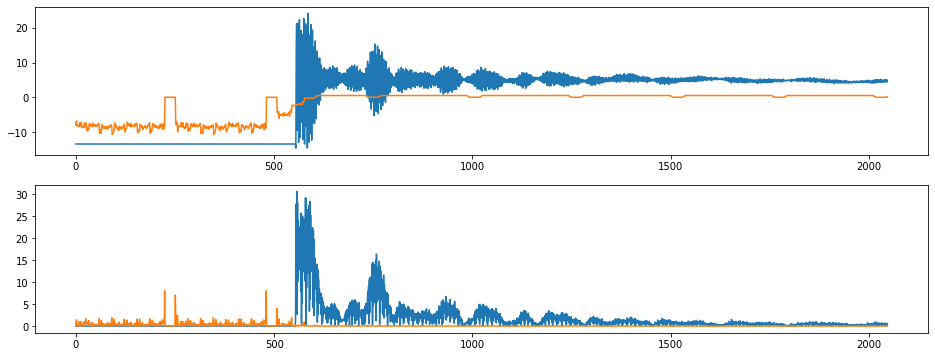

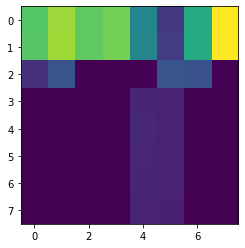

index:  402080
MAE:  5.175943244031659
n_bunches       1020
bunch_index      379
bunch_number     283
Name: 5254020, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6596/instability_data/06596_Inst_B1H_Q7_20180423_09h23m27s.h5


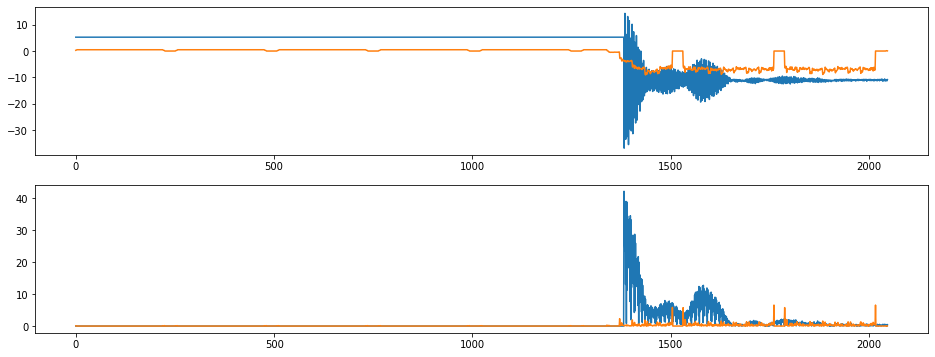

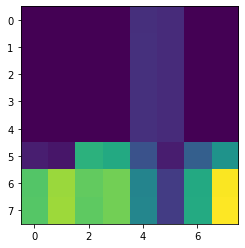

index:  305989
MAE:  5.034211252394307
n_bunches       2556
bunch_index     2490
bunch_number    1836
Name: 6221752, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_23h44m14s.h5


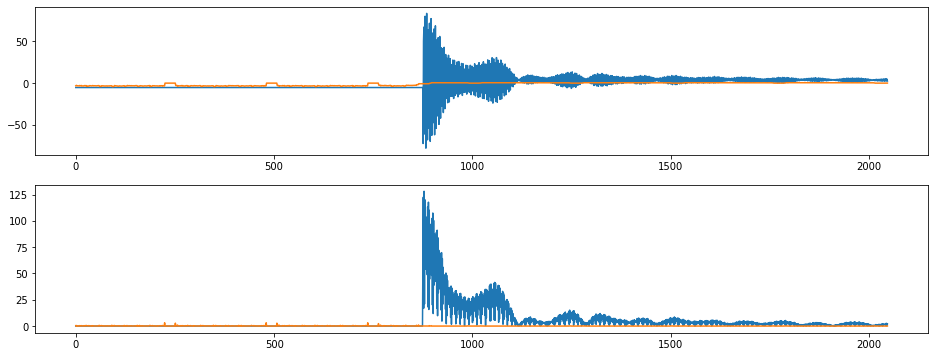

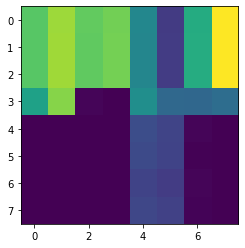

index:  158683
MAE:  5.020044672800868
n_bunches       2556
bunch_index     2413
bunch_number    1773
Name: 3614763, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6650/instability_data/06650_Inst_B1H_Q7_20180507_12h11m13s.h5


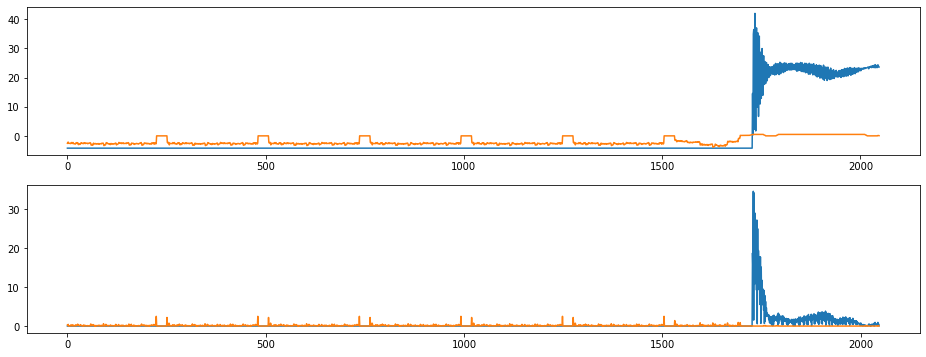

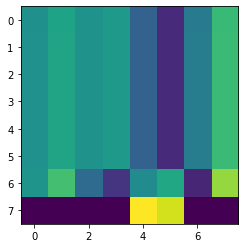

index:  101723
MAE:  4.973042113689006
n_bunches       2556
bunch_index      107
bunch_number      39
Name: 8085747, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_04h45m14s.h5


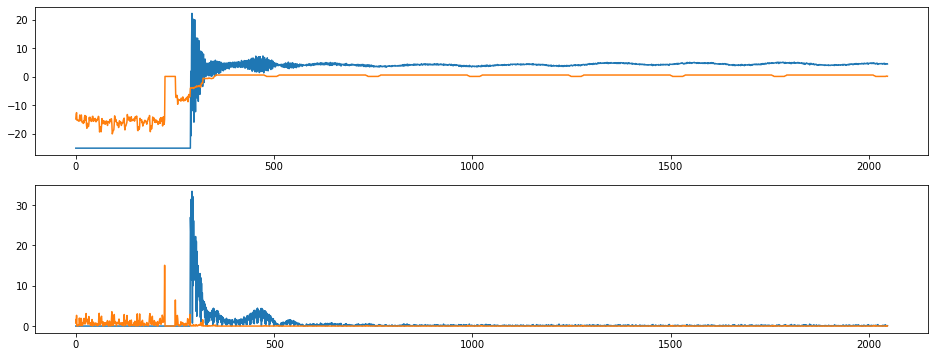

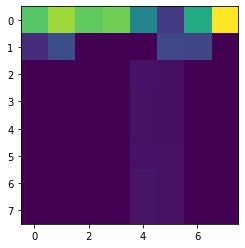

index:  128199
MAE:  4.935591454998649
n_bunches       158
bunch_index     299
bunch_number     78
Name: 3774309, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6797/instability_data/06797_Inst_B1H_Q7_20180614_23h56m14s.h5


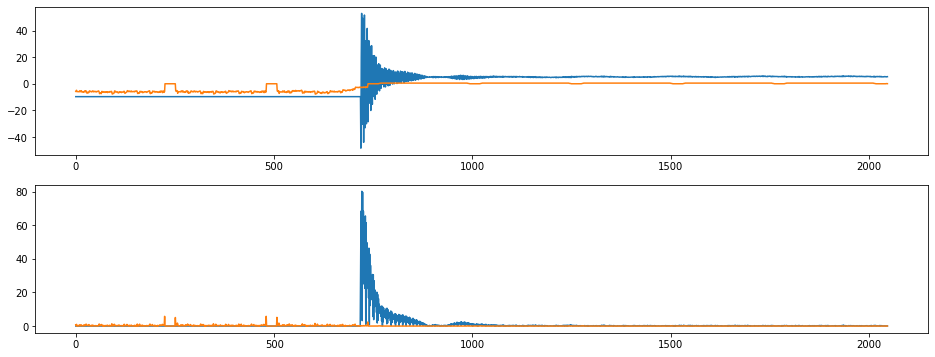

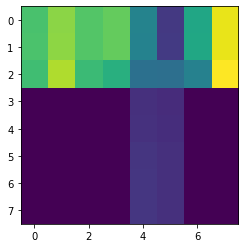

index:  337589
MAE:  4.912001432258403
n_bunches       924
bunch_index     101
bunch_number     52
Name: 4746026, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7068/instability_data/07068_Inst_B1H_Q7_20180820_00h37m22s.h5


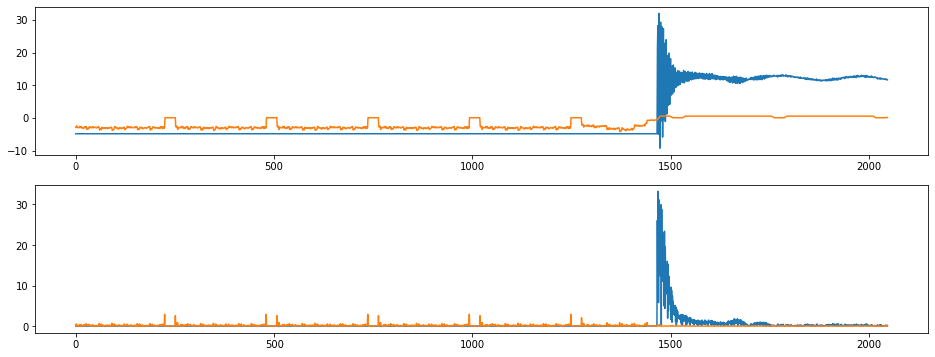

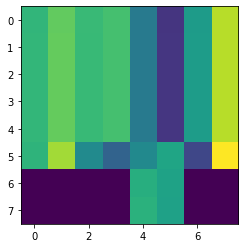

index:  346068
MAE:  4.7138082362315625
n_bunches        670
bunch_index     2231
bunch_number     469
Name: 1326840, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_00h21m14s.h5


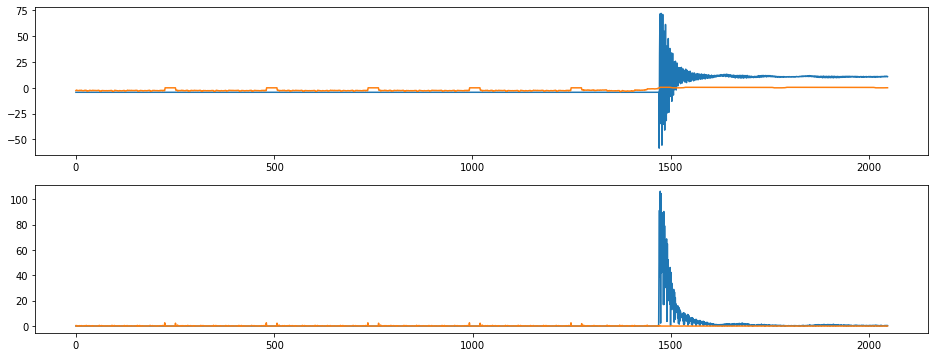

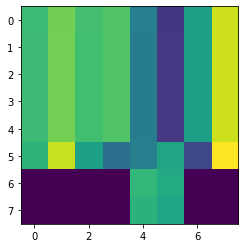

index:  255002
MAE:  4.7090841454086325
n_bunches       396
bunch_index     673
bunch_number    353
Name: 758141, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h18m14s.h5


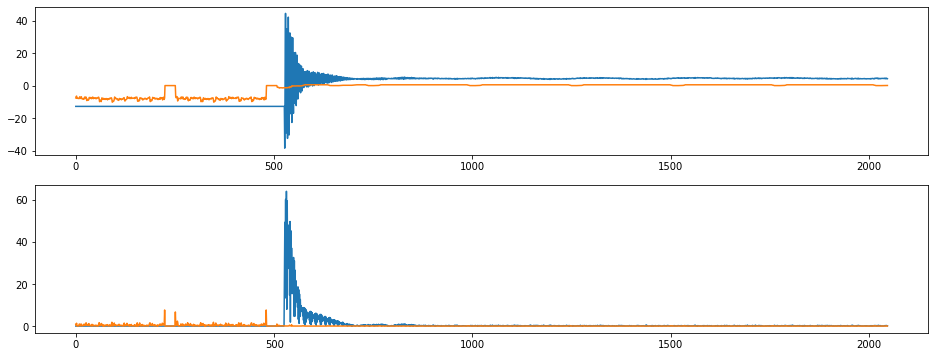

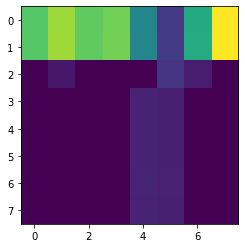

index:  50400
MAE:  4.697919483624137
n_bunches       158
bunch_index     110
bunch_number     12
Name: 6072040, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6798/instability_data/06798_Inst_B1H_Q7_20180615_02h43m15s.h5


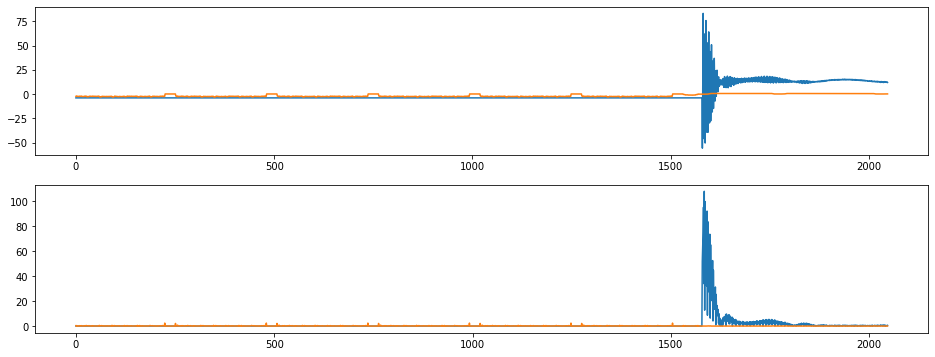

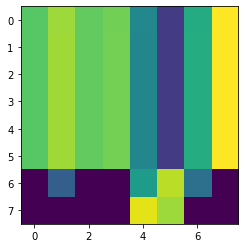

index:  393631
MAE:  4.535940163545165
n_bunches       108
bunch_index     120
bunch_number     64
Name: 2426061, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h07m26s.h5


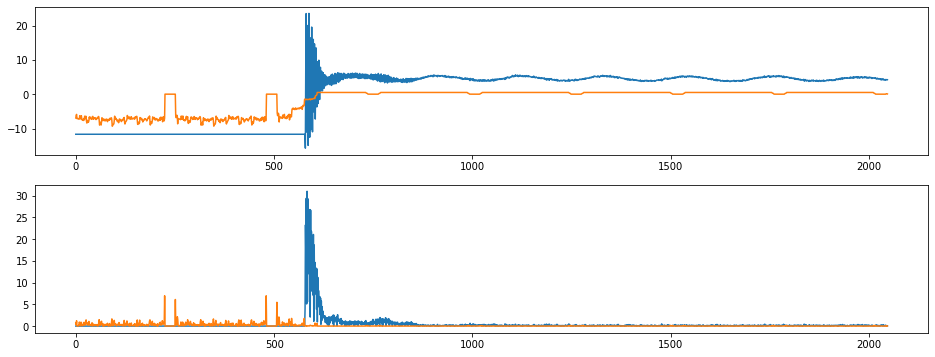

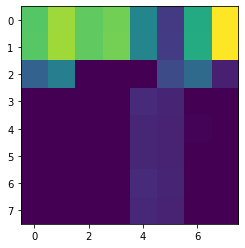

index:  100746
MAE:  4.511098746669159
n_bunches        781
bunch_index     1224
bunch_number     711
Name: 9898935, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6630/instability_data/06630_Inst_B1H_Q7_20180502_01h08m18s.h5


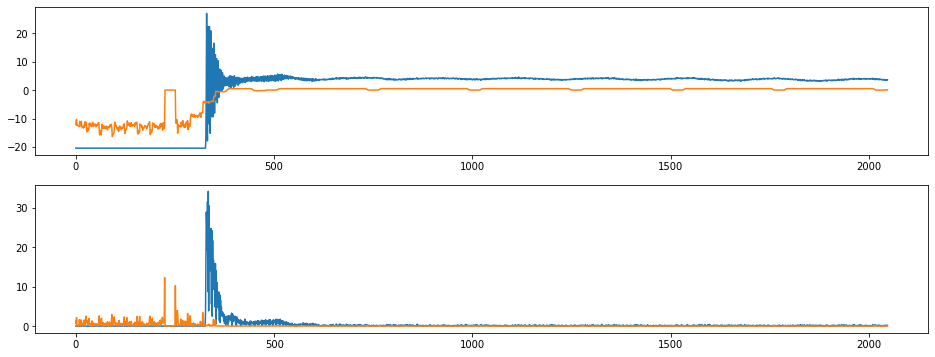

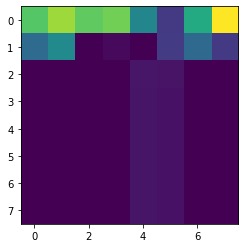

index:  249331
MAE:  4.16647838934412
n_bunches       1868
bunch_index     2922
bunch_number    1570
Name: 1545265, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171107_02h22m14s.h5


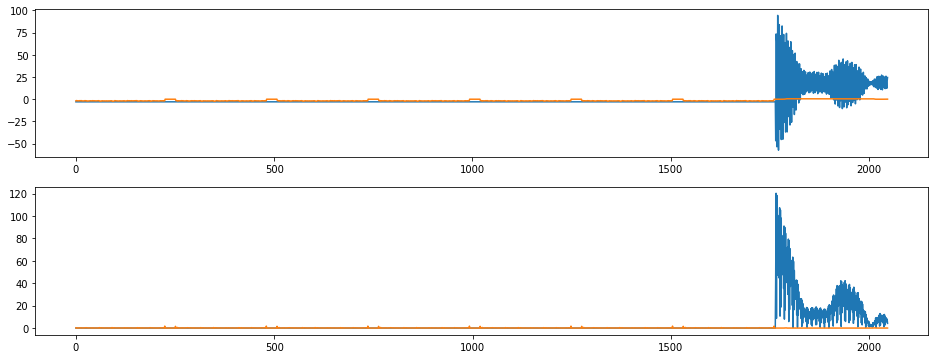

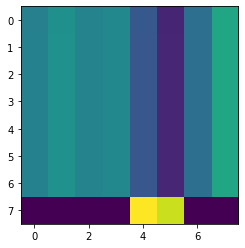

index:  300512
MAE:  4.162787114910607
n_bunches       2556
bunch_index      216
bunch_number     129
Name: 10248713, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_14h30m14s.h5


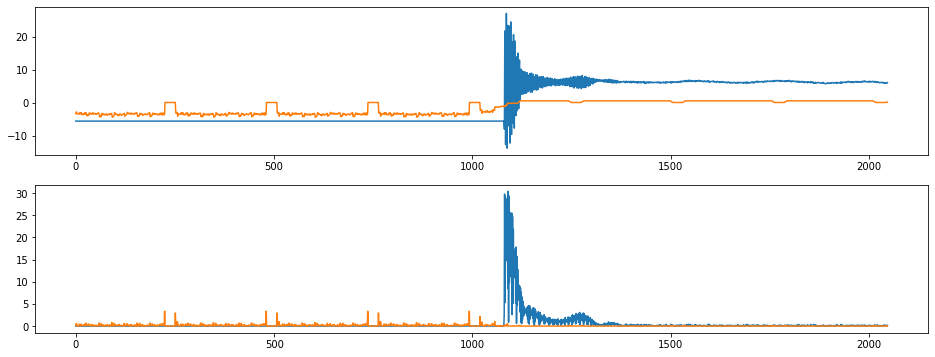

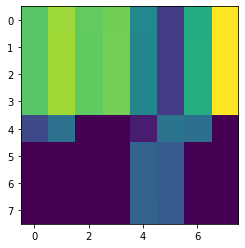

index:  369084
MAE:  3.9570975735348477
n_bunches       1212
bunch_index      415
bunch_number     283
Name: 3058780, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6921/instability_data/06921_Inst_B1H_Q7_20180714_15h07m14s.h5


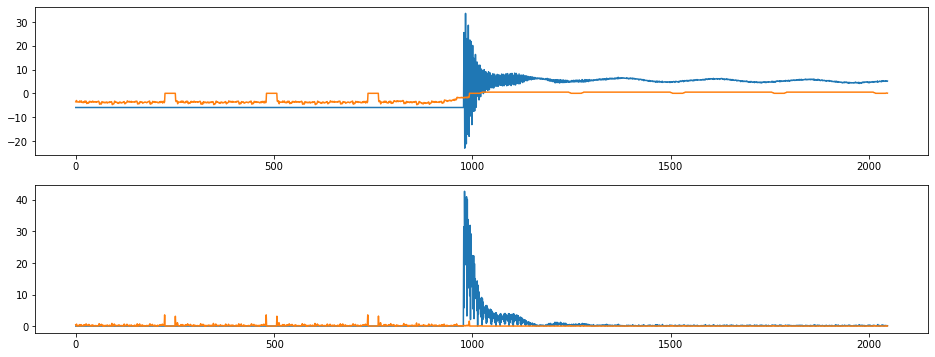

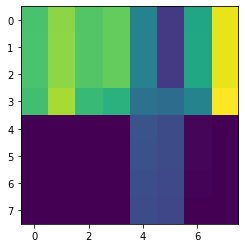

index:  92368
MAE:  3.954762927566189
n_bunches       396
bunch_index      66
bunch_number     17
Name: 10621350, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6940/instability_data/06940_Inst_B1H_Q7_20180718_04h54m17s.h5


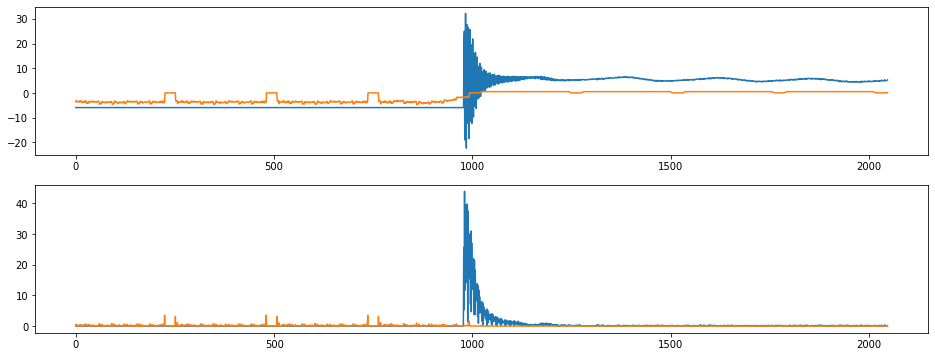

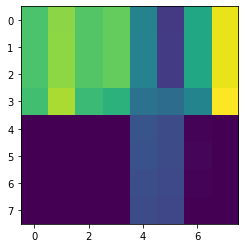

index:  397909
MAE:  3.9484629982021575
n_bunches        11
bunch_index     400
bunch_number      7
Name: 2924219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6493/instability_data/06493_Inst_B1H_Q7_20180401_17h48m47s.h5


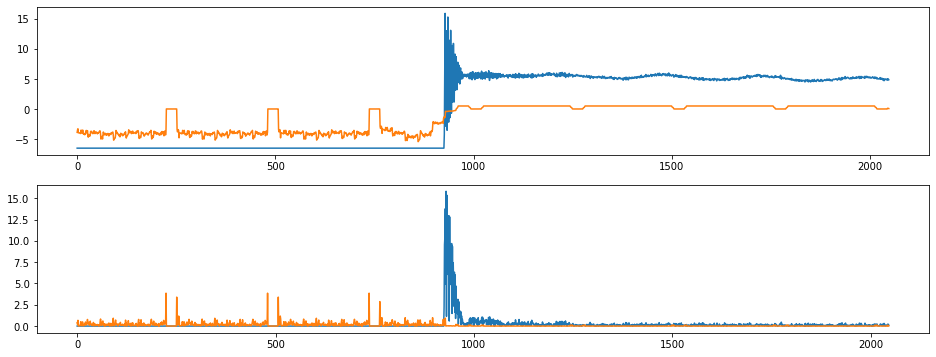

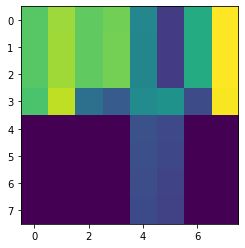

index:  217519
MAE:  3.7758523486518243
n_bunches       684
bunch_index     360
bunch_number    181
Name: 3402025, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m19s.h5


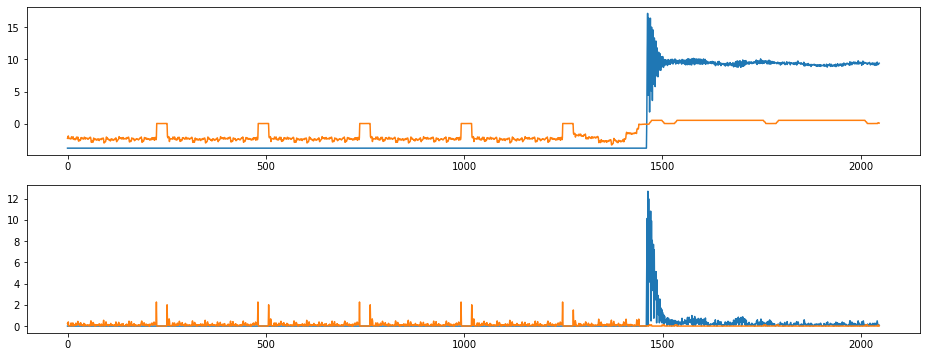

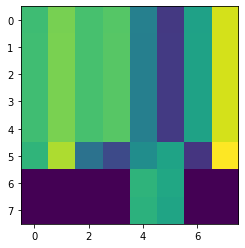

index:  222092
MAE:  3.706840069473292
n_bunches       1596
bunch_index      336
bunch_number     241
Name: 1249745, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170916_23h39m32s.h5


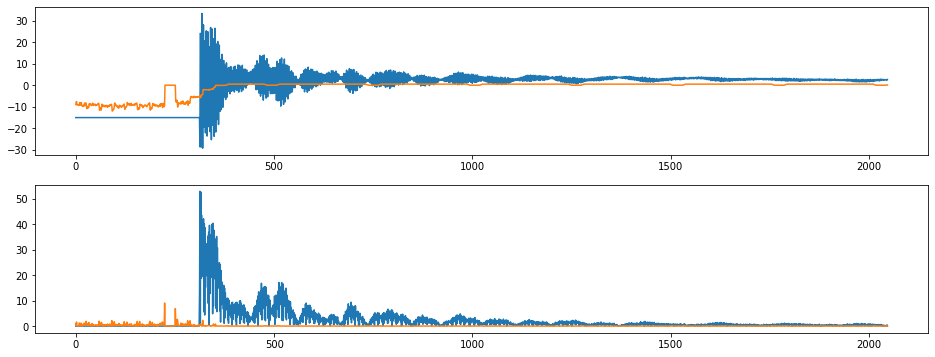

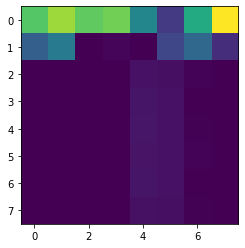

index:  29906
MAE:  3.661354748994272
n_bunches       572
bunch_index     186
bunch_number     85
Name: 4488565, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170928_13h03m23s.h5


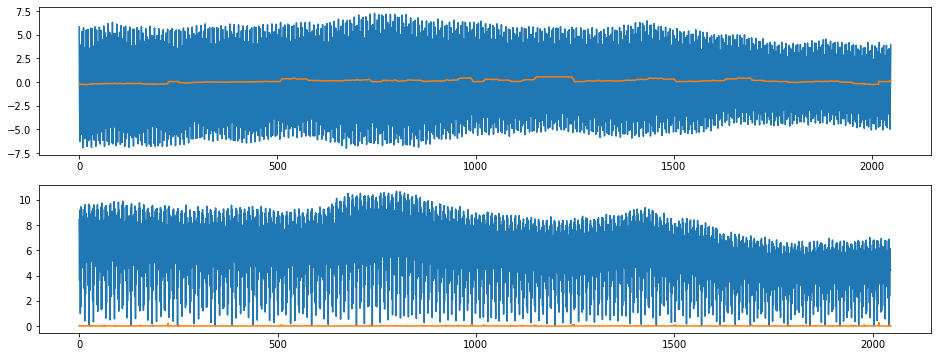

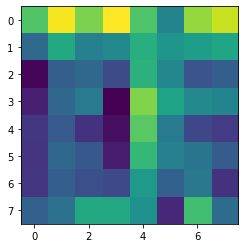

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()